#1.Montiamo Google drive cosi da poter caricare i file  e usiamo un comando per visualizzare i file presenti nella cartella


#Disattiviamo i warnings; potrebbe dare nel file di output messaggi di avviso, non rilevanti, li disattiviamo per tenere pulito il file pdf finale

In [ ]:
import os
# Disattiva i messaggi C++ INFO e WARNING (valore 2)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=Warning)

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)


In [ ]:
import pandas as pd
from google.colab import drive
import os
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
import folium
from matplotlib.colors import LinearSegmentedColormap
import nbformat
from nbconvert import HTMLExporter
from google.colab import drive, files
from scipy import signal
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
for w in [UserWarning, DeprecationWarning, FutureWarning]:
    warnings.filterwarnings("ignore", category=w)

try:
    from pandas.errors import SettingWithCopyWarning
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
except ImportError:
    pass

In [ ]:
drive.mount('/content/drive')

# Let's see a list of files on the directory
!ls '/content/drive/MyDrive/Etna2018'

Mounted at /content/drive
'Etna2018_V2.xlsx - terremoti.csv'   'Etna2018.xlsx - descrizione dati.csv'
'Etna2018.xlsx - 3He-4He ratio.csv'  'Etna2018.xlsx - HCl_flux.csv'
'Etna2018.xlsx - clinometria.csv'    'Etna2018.xlsx - heat flux.csv'
'Etna2018.xlsx - CO2_flux.csv'	     'Etna2018.xlsx - SO2 flux.csv'
'Etna2018.xlsx - CO2-SO2 ratio.csv'  'Etna2018.xlsx - tremore vulcanico.csv'


#1.1Pulizia e correzioni degli errori in ciascun file uno dopo l'altro
Per ogni file faremo:


*   Pulizia dati:correzione formate data, aggiunta nomi colonna mancanti, gestione valori nulli e outlier, formattazione spazi e virgolettati
*   Visualizzazione grafica distribuzione dati dopo aver sistemato tutto
* Visualizzazione prime righe file dopo aver corretto



1.2 **Heat-Flux : **



*   Rinominiamo colonna contenente le date in Datetime, visto che era senza nome
*   Controlliamo il tipo di dati e lo convertiamo nel formato tempo corretto
*   Verifichiamo se ci sono valori nulli
*   Eliminiamo duplicati
*   Filtriamo gli outlier, i valori diversi dal resto dei dati
*   Rappresentazione grafica del flusso di calore, dopo aver pulito i dati















In [ ]:
# First of all read the file on which analysis is based
df = pd.read_csv('/content/drive/MyDrive/Etna2018/Etna2018.xlsx - heat flux.csv')

# Rename time column in "Date"
df = df.rename(columns={df.columns[0]: 'date'})

# Save result in a new result
df.to_csv('heat_flux_with_dates.csv', index=False)

In [ ]:
# 1. Read file and rename column
df = pd.read_csv('/content/drive/MyDrive/Etna2018/Etna2018.xlsx - heat flux.csv')
df = df.rename(columns={df.columns[0]: 'date'})

# 2. Clean data
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y %H.%M')
df['Radiant Heat Flux [W]'] = (
    df['Radiant Heat Flux [W]']
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# 3. Manage datetime
df = df.sort_values('date').drop_duplicates('date')
df = df.set_index('date').asfreq('1min').reset_index()


# 4. Manage outliers
Q1 = df['Radiant Heat Flux [W]'].quantile(0.25)
Q3 = df['Radiant Heat Flux [W]'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Radiant Heat Flux [W]'] >= (Q1 - 3*IQR)) & (df['Radiant Heat Flux [W]'] <= (Q3 + 3*IQR))]



# 5. Saved clean file
df.to_csv('heat_flux_cleaned.csv', index=False)

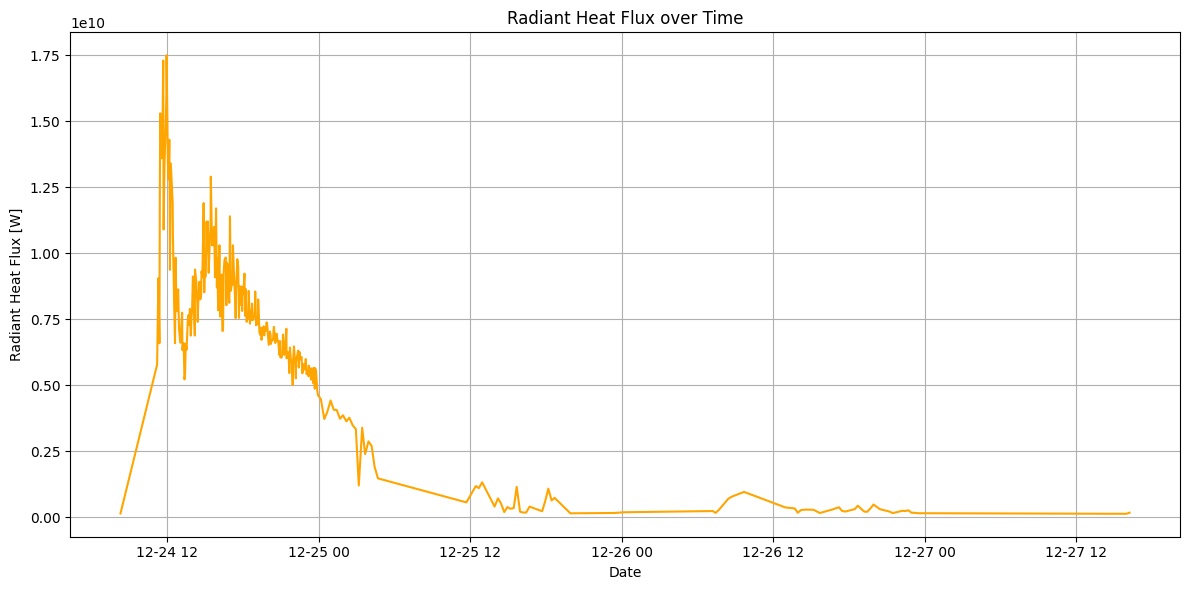

In [ ]:
# Loading clean file
df = pd.read_csv('heat_flux_cleaned.csv')

# Let's be sure that datetime column is date
df['date'] = pd.to_datetime(df['date'])

# Set up datetime column as index for the graph
df = df.set_index('date')

# Creation of the graph
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Radiant Heat Flux [W]'], color='orange')
plt.title('Radiant Heat Flux over Time')
plt.xlabel('Date')
plt.ylabel('Radiant Heat Flux [W]')
plt.grid(True)
plt.tight_layout()
plt.show()

#Visualizziamo il heat_flux pulito, le prime righe con le correzioni apportate

In [ ]:
# Loading cleaned file
df = pd.read_csv('heat_flux_cleaned.csv')

# Let's be sure that 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Mostra le prime 10 righe per un rapido controllo
print("First 10 rows of cleaned Dataframe:")
print(df.head(10))

# Show some summary informations
print("\ngenerale information on Dataframe:")
print(df.info())

print("\ndescriptive statistics:")
print(df.describe())

First 10 rows of cleaned Dataframe:
                 date  Radiant Heat Flux [W]
0 2018-12-24 08:19:00           1.410000e+08
1 2018-12-24 11:13:00           5.780000e+09
2 2018-12-24 11:19:00           9.050000e+09
3 2018-12-24 11:24:00           6.590000e+09
4 2018-12-24 11:26:00           1.250000e+10
5 2018-12-24 11:28:00           1.530000e+10
6 2018-12-24 11:34:00           1.360000e+10
7 2018-12-24 11:38:00           1.410000e+10
8 2018-12-24 11:42:00           1.730000e+10
9 2018-12-24 11:44:00           1.090000e+10

generale information on Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   285 non-null    datetime64[ns]
 1   Radiant Heat Flux [W]  285 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 KB
None

descriptive statistics:
    

1.2 #**SO2flux:**
Visualizziamo le ultime 5 righe e vediamo che ci sono gli stessi problemi.
Sistemiamo il format, trasformando da format letterali a numerici (da feb a 02), aggiustiamo i separatori e la colonna date e rappresentiamo graficamente di nuovo

In [ ]:
# Loading SO2 file
file_path = '/content/drive/MyDrive/Etna2018/Etna2018.xlsx - SO2 flux.csv'

# Read file with optimized parameters
so2flux = pd.read_csv(
    file_path,
    skiprows=1,
    decimal=',',
    thousands='.',
    parse_dates=['Date'],
    dayfirst=True
)

# Cleaning numeric column
so2flux['daily SO2 flux (t/d)'] = pd.to_numeric(
    so2flux['daily SO2 flux (t/d)'].astype(str)
    .str.replace('[^\d,]', '', regex=True)
    .str.replace(',', '.', regex=False),
    errors='coerce'
)

# Set time index
so2flux.set_index('Date', inplace=True)

# Print some rows of cleaned dataset
print(f"Number of SO2 flux observations: {len(so2flux)}")
print("\nlast 5 records")
print(so2flux.tail())

Number of SO2 flux observations: 671

last 5 records
           daily SO2 flux (t/d)
Date                           
22-feb-19                305576
23-feb-19                105591
25-feb-19                235755
27-feb-19                149822
28-feb-19                221421


Sulla stessa variabile il flusso/emissione di anidride solforosa, rappresento due grafici per visualizzare i dati e la distribuzione

In [ ]:
# 1. Reading file
df = pd.read_csv('/content/drive/MyDrive/Etna2018/Etna2018.xlsx - SO2 flux.csv', skiprows=1)

# 2. Cleaning datetime
month_map = {
    'gen': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'apr': 'Apr',
    'mag': 'May', 'giu': 'Jun', 'lug': 'Jul', 'ago': 'Aug',
    'set': 'Sep', 'ott': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

df['Date'] = df['Date'].replace(month_map, regex=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# 3. Converting numeric values
df['daily SO2 flux (t/d)'] = (
    df['daily SO2 flux (t/d)']
    .str.replace(',', '.')
    .str.replace('"', '')
    .astype(float)
)

# 4. Managing missing date
full_range = pd.date_range(
    start=df['Date'].min(),
    end=df['Date'].max(),
    freq='D'
)



df = df.set_index('Date').reindex(full_range).reset_index()
df = df.rename(columns={
    'index': 'date',
    'daily SO2 flux (t/d)': 'SO2_flux_t_d'
})


# 7. Saving cleaned file
df.to_csv('SO2_flux_cleaned.csv', index=False)

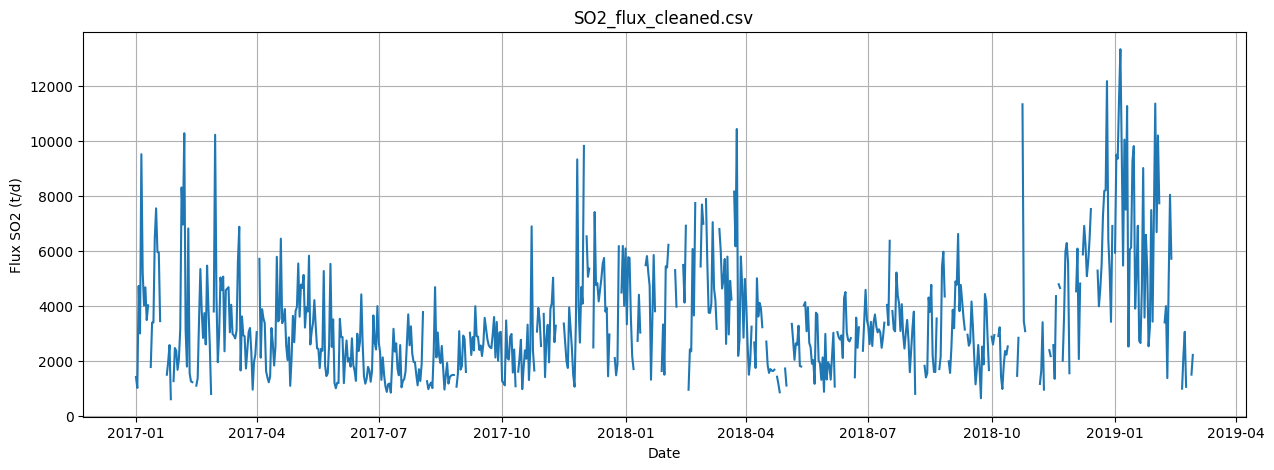

In [ ]:
#Visualize graph
plt.figure(figsize=(15,5))
plt.plot(df['date'], df['SO2_flux_t_d'])
plt.title('SO2_flux_cleaned.csv')
plt.xlabel('Date')
plt.ylabel('Flux SO2 (t/d)')
plt.grid()
plt.show()

In [ ]:
# Loading cleaned file
df = pd.read_csv('SO2_flux_cleaned.csv')

# Showing first 10 column
print("First 10 rows of cleaned dataset")
print(df.head(10))


First 10 rows of cleaned dataset
         date  SO2_flux_t_d
0  2017-01-01       1411.79
1  2017-01-02       1016.61
2  2017-01-03       4720.25
3  2017-01-04       2995.22
4  2017-01-05       9504.67
5  2017-01-06       5194.17
6  2017-01-07       4009.46
7  2017-01-08       4670.08
8  2017-01-09       3480.77
9  2017-01-10       4016.83


# 1.3 HCI_FLUX
Dalla pulizia dati iniziale possiamo notare ci sono meno outlier, infatti possiamo vedere molti FALSE in corrispondenza della voce outlier.

In [ ]:
def clean_hcl_flux(input_file, output_file):
    """

    Args:
        input_file (str): Input file path
        output_file (str): Output file path
    """

    # 1. Loading data skipping firs useless rows
    df = pd.read_csv(input_file, skiprows=1)

    # 2. Verifying starting structure
    print("\nStrarting structure of the dataset:")
    print(df.head())
    print(f"\nNumber of original rows: {len(df)}")

    # 3. Cleaning columns
    df.columns = df.columns.str.strip()

    # 4. Managing missing values
    print("\nMissing values before the cleaning")
    print(df.isnull().sum())

    # If necessary removing rows with missing values
    df = df.dropna()

    # 5. Converting and uniforming date
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    except:
        # Trying another format
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

    # 6. Sort by datetime
    df = df.sort_values('Date')

    # 7. Check and manage outlier
    Q1 = df['daily HCl flux (t/d)'].quantile(0.25)
    Q3 = df['daily HCl flux (t/d)'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifying outlier
    df['outlier'] = ~df['daily HCl flux (t/d)'].between(lower_bound, upper_bound)

    print(f"\nNumber of potential outlier identified: {df['outlier'].sum()}")
    print("\nOutlier identified:")
    print(df[df['outlier'] == True])

    # 8. CHeck duplicate values
    duplicates = df.duplicated(subset=['Date'], keep=False)
    if duplicates.any():
        print(f"\nFound {duplicates.sum()} duplicated. Verify:")
        print(df[duplicates])

        df = df.drop_duplicates(subset=['Date'], keep='first')

    # 9. Verifying non numeric values
    non_numeric = pd.to_numeric(df['daily HCl flux (t/d)'], errors='coerce').isna()
    if non_numeric.any():
        print(f"\nfound {non_numeric.sum()} non numeric values. Verify:")
        print(df[non_numeric])
        # Converting in numeric and settling as "Nan" non convertibles ones
        df['daily HCl flux (t/d)'] = pd.to_numeric(df['daily HCl flux (t/d)'], errors='coerce')

    # 10. Verifying negative values
    negatives = df['daily HCl flux (t/d)'] < 0
    if negatives.any():
        print(f"\nTrovati {negatives.sum()} valori negativi. Verifica:")
        print(df[negatives])

        df.loc[negatives, 'daily HCl flux (t/d)'] = np.nan

    # 11. Removing rows with missing values eventually
    df = df.dropna()

    # 12. Final format
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # 13. Saving cleaned file
    df.to_csv(output_file, index=False)

    # 14. Final report
    print("\ncleaning successfully completed!")
    print(f"Number of rows in cleaned file: {len(df)}")
    print(f"File saved as: {output_file}")

    return df

# Using script
if __name__ == "__main__":
    input_file = "/content/drive/MyDrive/Etna2018/Etna2018.xlsx - HCl_flux.csv"
    output_file = "HCl_flux_clean.csv"

    cleaned_data = clean_hcl_flux(input_file, output_file)

    # View first 5 rows
    print("\nfirst 5 rows of cleaned dataset:")
    print(cleaned_data.head())


Strarting structure of the dataset:
        Date  daily HCl flux (t/d)
0  19/1/2017                   483
1  25/1/2017                   321
2  31/1/2017                   533
3   3/2/2017                   681
4   8/2/2017                   568

Number of original rows: 64

Missing values before the cleaning
Date                    0
daily HCl flux (t/d)    0
dtype: int64

Number of potential outlier identified: 1

Outlier identified:
        Date  daily HCl flux (t/d)  outlier
7 2017-03-01                  1723     True

cleaning successfully completed!
Number of rows in cleaned file: 64
File saved as: HCl_flux_clean.csv

first 5 rows of cleaned dataset:
         Date  daily HCl flux (t/d)  outlier
0  2017-01-19                   483    False
1  2017-01-25                   321    False
2  2017-01-31                   533    False
3  2017-02-03                   681    False
4  2017-02-08                   568    False


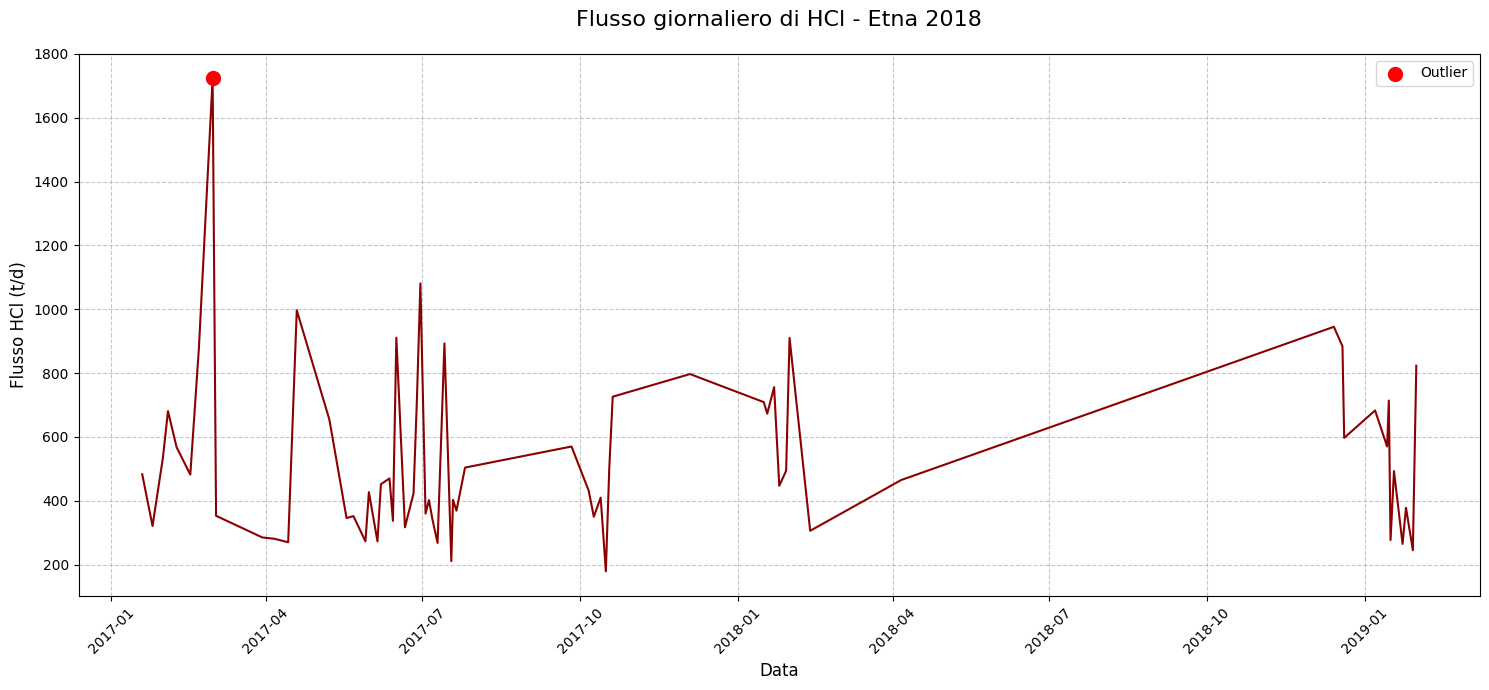

In [ ]:
def plot_hcl_flux(df):
    """
    Function to show HCI flux during time

    Args:
        df (DataFrame): DataFrame containg cleaned data
    """
    # Converting the column in Datetime for plotting
    df['Date'] = pd.to_datetime(df['Date'])

    # Creating the figure
    plt.figure(figsize=(15, 7))

    # Line graph of flux during the time
    sns.lineplot(data=df, x='Date', y='daily HCl flux (t/d)',
                 color='darkred', linewidth=1.5)

    # Showing outlier if present in columns
    if 'outlier' in df.columns:
        outliers = df[df['outlier'] == True]
        plt.scatter(outliers['Date'], outliers['daily HCl flux (t/d)'],
                   color='red', s=100, label='Outlier', zorder=5)

    # Formatting graph
    plt.title('Flusso giornaliero di HCl - Etna 2018', fontsize=16, pad=20)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Flusso HCl (t/d)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Improve readibality of labels
    plt.xticks(rotation=45)


    if 'outlier' in df.columns:
        plt.legend()

    plt.tight_layout()
    plt.show()

# Usage after clean the data
if __name__ == "__main__":
    # Loading cleaned data
    cleaned_data = pd.read_csv("HCl_flux_clean.csv")

    # Generating graph
    plot_hcl_flux(cleaned_data)

In [ ]:
def display_clean_data_head(cleaned_data):
    """
    Function to visualize first 5 rows of cleaned DataFrame

    Args:
        cleaned_data (DataFrame): DataFrame clened
    """
    # Creating a copy to avoid modification of the original one
    display_df = cleaned_data.head().copy()

    # Format improved for the visualization
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')

    print("\n" + "="*70)
    print("First 5 rows of cleaned dataframe".center(70))
    print("="*70 + "\n")

    # View DataFrame
    display(display_df.style
            .set_properties(**{'background-color': '#f7f7f7',
                             'color': '#333333',
                             'border': '1px solid #cccccc'})
            .format({'daily HCl flux (t/d)': '{:.2f}'})
            .set_table_styles([{'selector': 'th',
                               'props': [('background-color', '#4a6baf'),
                                        ('color', 'white'),
                                        ('font-weight', 'bold')]}]))


    print("\n" + "-"*70)
    print(f"Total number of rows of cleaned dataframe: {len(cleaned_data)}")
    print(f"Number of columns: {len(cleaned_data.columns)}")
    print("Available columns:", list(cleaned_data.columns))

    if 'outlier' in cleaned_data.columns:
        total_outliers = cleaned_data['outlier'].sum()
        print(f"\nTotal number of identified outliers: {total_outliers}")



if __name__ == "__main__":
    input_file = "/content/drive/MyDrive/Etna2018/Etna2018.xlsx - HCl_flux.csv"
    output_file = "HCl_flux_clean.csv"

    # Let's execute cleaning of data
    cleaned_data = clean_hcl_flux(input_file, output_file)

    # Visualization of first 5 rows with improved formatting
    display_clean_data_head(cleaned_data)


Strarting structure of the dataset:
        Date  daily HCl flux (t/d)
0  19/1/2017                   483
1  25/1/2017                   321
2  31/1/2017                   533
3   3/2/2017                   681
4   8/2/2017                   568

Number of original rows: 64

Missing values before the cleaning
Date                    0
daily HCl flux (t/d)    0
dtype: int64

Number of potential outlier identified: 1

Outlier identified:
        Date  daily HCl flux (t/d)  outlier
7 2017-03-01                  1723     True

cleaning successfully completed!
Number of rows in cleaned file: 64
File saved as: HCl_flux_clean.csv

                  First 5 rows of cleaned dataframe                   



,Date,daily HCl flux (t/d),outlier
0,2017-01-19,483.00,False
1,2017-01-25,321.00,False
2,2017-01-31,533.00,False
3,2017-02-03,681.00,False
4,2017-02-08,568.00,False



----------------------------------------------------------------------
Total number of rows of cleaned dataframe: 64
Number of columns: 3
Available columns: ['Date', 'daily HCl flux (t/d)', 'outlier']

Total number of identified outliers: 1


#1.4 3HE-4HE_ratio:
direttamente puliamo il file, e rappresentiamo i box plot di ogni variabile, boxplot comparativi facendo il confronto tra loro

In [ ]:
def clean_he_ratio(input_file, output_file):

    # Loading with managing problematics rows
    df = pd.read_csv(input_file, skiprows=1)

    # Remove fully empty rows
    df = df[~df['Date'].str.contains('n.a.:', na=False)]
    df = df.dropna(how='all')

    # Managing missing values
    df.replace('n.a.', np.nan, inplace=True)

    # Converting datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')


    df = df.dropna(subset=['Date'])

    # Converting numbers
    for col in df.columns[1:]:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

    # Sorting
    df = df.sort_values('Date')

    # Verification of duplicates
    if df.duplicated(subset=['Date']).any():
        df = df.drop_duplicates(subset=['Date'], keep='first')

    # Saving
    df.to_csv(output_file, index=False)
    return df

if __name__ == "__main__":

    cleaned_data = clean_he_ratio('/content/drive/MyDrive/Etna2018/Etna2018.xlsx - 3He-4He ratio.csv', 'cleaned_he_ratio.csv')
    print("Dati puliti salvati in 'cleaned_he_ratio.csv'")
    print(cleaned_data.head())

Dati puliti salvati in 'cleaned_he_ratio.csv'
     Date     Stadio  Fondachello   P39  Vallone Salato  Naftia
0 2017-01-13   6.32      6.44      7.10       6.58        6.58 
1 2017-02-06   6.31      6.42      7.09       6.57        6.57 
2 2017-03-02   6.30      6.38      7.04       6.56        6.56 
3 2017-03-24   6.27      6.35      7.00       6.53        6.50 
4 2017-04-12   6.30      6.40      7.03       6.55        6.54 


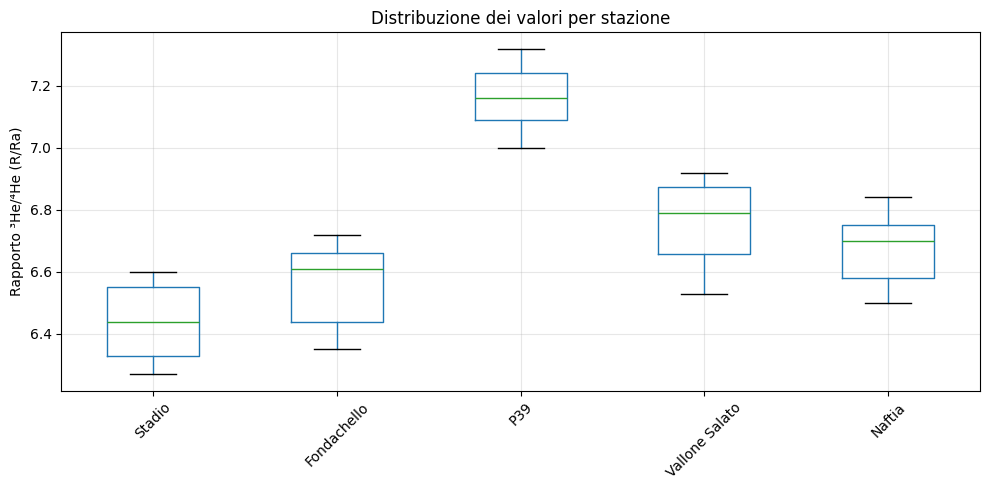

In [ ]:
# Loading cleaned data
df = pd.read_csv('cleaned_he_ratio.csv', parse_dates=['Date'])

# Extraction of station names
stations = df.columns[1:].tolist()

# Boxplot
plt.figure(figsize=(10, 5))
df.boxplot(column=stations)
plt.title('Distribuzione dei valori per stazione')
plt.ylabel('Rapporto ³He/⁴He (R/Ra)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#1.5 CO2-SO2 flux:
facciamo la stessa cosa qui concentrandoci su una visualizzazione grafica che evidenzi gli outlier

In [ ]:
def   # 1. Loading data
    try:
        df = pd.read_csv(input_file, skiprows=1)
    except Exception as e:
        print(f"Error on loading file: {e}")
        return None

    # 2. Starting cleaning
    df.columns = df.columns.str.strip()

    # 3. Converting numeric values
    df['CO2/SO2'] = (df['CO2/SO2']
                     .astype(str)
                     .str.replace(',', '.')
                     .replace('nan', np.nan)
                     .astype(float))

    # 4. Converting datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])


    df = df.drop_duplicates(subset=['Date', 'CO2/SO2'])


    df['Is_Outlier'] = df['CO2/SO2'] > 20


    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Date_only'] = df['Date'].dt.date


    df = df.sort_values('Date')

    # 9. Saving
    df.to_csv(output_file, index=False)


    print(f"Cleaning completed. Data saved in {output_file}")
    print(f"\nStatistics:")
    print(f"- Total rows: {len(df)}")
    print(f"- Outliers (>20): {df['Is_Outlier'].sum()}")
    print(f"- Cover period: {df['Date'].min().date()} - {df['Date'].max().date()}")
    print(f"- Mean value: {df['CO2/SO2'].mean():.2f} ± {df['CO2/SO2'].std():.2f}")

    return df

# Usage of script
if __name__ == "__main__":
    input_path = "/content/drive/MyDrive/Etna2018/Etna2018.xlsx - CO2-SO2 ratio.csv"
    output_path = "cleaned_CO2_SO2_ratio.csv"

    cleaned_data = clean_co2_so2_data(input_path, output_path)

    # Fast visualization of results
    if cleaned_data is not None:
        print("\nPreview of cleaned data:")
        print(cleaned_data.head())f clean_co2_so2_data(input_file, output_file):



SyntaxError: invalid syntax (ipython-input-296927152.py, line 1)

In [ ]:
def plot_results(cleaned_file):
    df = pd.read_csv(cleaned_file, parse_dates=['Date'])

    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['CO2/SO2'], 'o', markersize=3, label='Data')
    plt.plot(df[df['Is_Outlier']]['Date'],
             df[df['Is_Outlier']]['CO2/SO2'],
             'rx', label='Outlier (>20)')
    plt.title('Trend of  CO2/SO2 ratio  during the time')
    plt.xlabel('Date')
    plt.ylabel('CO2/SO2 ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('co2_so2_trend.png', dpi=300)
    plt.show()

plot_results('cleaned_CO2_SO2_ratio.csv')

#1.6 CO2_flux:
puliamo il file, rinominiamo le colonne, aggiustiamo il formato e poi nello stesso script presentiamo i risultati grafici

In [ ]:
import pandas as pd

# Percorso file di input
input_file = "/content/drive/MyDrive/Etna2018/Etna2018.xlsx - CO2_flux.csv"
output_file = "CO2_flux.cleaned.csv"

# Carica il file saltando la prima riga descrittiva
df = pd.read_csv(input_file, skiprows=1)

# Rinomina le colonne (rimuove spazi extra)
df.columns = [col.strip() for col in df.columns]

# Converte la colonna dei numeri (virgola → punto)
df["f CO2_norm"] = df["f CO2_norm"].str.replace(",", ".", regex=False).astype(float)

# Converte la colonna delle date in formato datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Rimuove eventuali righe con dati mancanti
df = df.dropna()

# Salva il file pulito
df.to_csv(output_file, index=False)

print(f"File pulito salvato come: {output_file}")




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Percorso del file pulito
file_path = "CO2_flux.cleaned.csv"

# Carica i dati
df = pd.read_csv(file_path, parse_dates=["Date"])

# Mostra le prime righe
print("Prime righe del dataset:")
print(df.head())

# Statistiche descrittive
print("\nStatistiche di base:")
print(df["f CO2_norm"].describe())

# Grafico del flusso di CO2 nel tempo
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["f CO2_norm"], marker='o', linestyle='-', alpha=0.7)
plt.title("Flusso di CO₂ nel tempo (Etna 2018)")
plt.xlabel("Data")
plt.ylabel("Flusso CO₂ normalizzato")
plt.grid(True)
plt.tight_layout()
plt.show()


# 1.7 Clinometria:
in clinometria si evidenziano leggermente problemi in più, in quanto le colonne non sono separate, i titoli delle colonne non non sono etichettati in caselle diverse, ma sono separati da virgole e in più bisogna adattare le altre operazioni di pulizia, la colonna time al solito, eliminare colonne vuote e salvare il risultato; graficamente rappresento le distribuzioni cosi da capire la differenze tra una colonna e l'altra

In [ ]:
# Loading file
raw_df = pd.read_csv("/content/drive/MyDrive/Etna2018/Etna2018.xlsx - clinometria.csv", header=None)


split_df = raw_df[0].str.split(",", expand=True)


split_df.columns = split_df.iloc[0]
split_df = split_df.drop(index=0)


split_df["time"] = pd.to_datetime(split_df["time"], errors="coerce")


for col in split_df.columns:
    if col != "time":
        split_df[col] = pd.to_numeric(split_df[col], errors="coerce")


clean_df = split_df.dropna(subset=["time"]).dropna(how='all')


clean_df.reset_index(drop=True, inplace=True)

# Save result
clean_df.to_csv("clinometria_clean.csv", index=False)

print("Pulizia completata. File salvato come 'clinometria_clean.csv'")

In [ ]:
# Loading cleaned file
df = pd.read_csv("clinometria_clean.csv")


df["time"] = pd.to_datetime(df["time"], errors="coerce")

# Setting graphs style
sns.set(style="whitegrid")


numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=50, color="skyblue")
    plt.title(f"Distribuzione di {col}")
    plt.xlabel(col)
    plt.ylabel("Frequenza")
    plt.tight_layout()
    plt.show()

#time series
for col in numeric_cols:
    plt.figure(figsize=(14, 4))
    plt.plot(df["time"], df[col], label=col, color="dodgerblue", linewidth=0.5)
    plt.title(f"Andamento temporale di {col}")
    plt.xlabel("Tempo")
    plt.ylabel(col)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
#Loading cleaned files
clean_df = pd.read_csv("clinometria_clean.csv")

#Visualization of first 5 rows
print(clean_df.head())

#1.8 tremore vulcanico:
utilizzo RMS come misura per la visualizzazione grafica e mostro una suddivisione in cluster per distinguere bene i periodi di quiete con quelli più movimentati

In [ ]:
# Loading and starting cleaning
file_path = "/content/drive/MyDrive/Etna2018/Etna2018.xlsx - tremore vulcanico.csv"
df = pd.read_csv(file_path)
df.columns = ['Data', 'RMS']
df['RMS'] = df['RMS'].str.replace(',', '.', regex=False).astype(float)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values(by='Data').reset_index(drop=True)


print("Missing values first:\n", df.isnull().sum())
df.dropna(inplace=True)


Q1 = df['RMS'].quantile(0.25)
Q3 = df['RMS'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['RMS'] >= Q1 - 1.5*IQR) & (df['RMS'] <= Q3 + 1.5*IQR)]


print("Duplicated rows:", df.duplicated(subset=['Data']).sum())
df.drop_duplicates(subset=['Data'], keep='first', inplace=True)

# 4. Verifying RMS range
print("Missing values in RMS:\n", df[df['RMS'] < 0])


df = df.set_index('Data').asfreq('D').reset_index()

# Final result
print("\nCleaned Data:")
print(df.head())
print("\nStatistics RMS:\n", df['RMS'].describe())

# Salva il risultato
df.to_csv("tremore vulcanico_cleaned.csv", index=False)
print("Clean completed. File saved as tremore vulcanico_cleaned.csv'")

In [ ]:
# Loading and cleaning data
file_path = "/content/drive/MyDrive/Etna2018/Etna2018.xlsx - tremore vulcanico.csv"
df = pd.read_csv(file_path)
df.columns = ['Data', 'RMS']
df['RMS'] = df['RMS'].str.replace(',', '.', regex=False).astype(float)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values(by='Data').reset_index(drop=True)

# K-Means clustering su RMS
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['RMS']])


sns.set(style="whitegrid")
palette = sns.color_palette("Set1", n_colors=n_clusters)

# Graph
plt.figure(figsize=(14, 6))
for cluster in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Data'], cluster_data['RMS'],
                label=f"Cluster {cluster+1}", s=20, alpha=0.7,
                color=palette[cluster])

# Formatting
plt.plot(df['Data'], df['RMS'], color='lightgray', alpha=0.3, linewidth=1)
plt.title('Tremore vulcanico Etna 2018 - Clustering', fontsize=16)
plt.xlabel('Data')
plt.ylabel('RMS (m/s)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Loading data
data = pd.read_csv('/content/drive/MyDrive/Etna2018/Etna2018.xlsx - tremore vulcanico.csv', delimiter=',', decimal=',')
data['Data'] = pd.to_datetime(data['ECPNZ'], dayfirst=True)
data = data.sort_values('Data')


plt.figure(figsize=(12, 6))
plt.plot(data['Data'], data['RMS(m/s)'], label='Tremor Vulcanic', color='red')
plt.xlabel('Data')
plt.ylabel('RMS (m/s)')
plt.title('Trend of volcaninic tremor on Etna (2017-2018)')
plt.grid(True)
plt.legend()
plt.show()

# 1.9 terremoti:


*   Lancio una funzione che permette di mettere le coordinate di longitudine e latitudine in modo da visualizzare una mappa che mostri il segnale dove è stato registrato


*   Considerata l'importanza di questo file e dei dati per eventuali modelli da applicare durante l'analisi, ho deciso di mosrare più grafici in modo da catturare più aspetti


1.   Una distribuzione temporale per vedere quanti terremoti si verificano per ogni mese
2.   Istogramma con distribuzione prima della magnitudo e poi della profondità dei terremoti
3.  Mappa per vedere la densità dei terremoti, in quale zona, a quali coordinate geografiche corrispondono più rilevazioni
4.   Scatter-plot che mostri come varia la magnitudo al variare della profondità














In [ ]:
def clean_earthquake_data(file_path):
    # Loading data file
    df = pd.read_csv(file_path)


    numeric_cols = ['Lat (°N)', 'Long (°E)', 'Depth (km)', 'ML']
    for col in numeric_cols:

        df[col] = (df[col].astype(str)
                   .str.replace(',', '.', regex=False)
                   .astype(float))


    try:
        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Origin Time'], dayfirst=True)
    except:
        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Origin Time'])


    df.drop(['Date', 'Origin Time'], axis=1, inplace=True)


    df['Depth (km)'] = np.where((df['Depth (km)'] >= 0) & (df['Depth (km)'] < 1000),
                              df['Depth (km)'],
                              np.nan)


    cols = ['Datetime', 'Lat (°N)', 'Long (°E)', 'Depth (km)', 'ML']
    df = df[cols]


    df = df.drop_duplicates()


    df = df.sort_values('Datetime')


    df = df.reset_index(drop=True)

    return df


cleaned_data = clean_earthquake_data('/content/drive/MyDrive/Etna2018/Etna2018_V2.xlsx - terremoti.csv')

# Sving cleaned result
cleaned_data.to_csv('terremoti_puliti.csv', index=False)

print("Pulizia completata. Dati salvati in 'terremoti_puliti.csv'")

In [ ]:

def mostra_posizione(latitudine, longitudine):
    # Creating the map centered on coordinates
    mappa = folium.Map(
        location=[latitudine, longitudine],
        zoom_start=15,
        tiles="OpenStreetMap"
    )

    # Adding a marker on the position
    folium.Marker(
        [latitudine, longitudine],
        tooltip="position selected",
        popup=f"Lat: {latitudine}<br>Lon: {longitudine}"
    ).add_to(mappa)

    # Adding a circle to better visualize
    folium.Circle(
        radius=200,
        location=[latitudine, longitudine],
        color="red",
        fill=True,
        fill_opacity=0.2
    ).add_to(mappa)

    # Saving map
    nome_file = f"mappa_{latitudine}_{longitudine}.html"
    mappa.save(nome_file)

    print(f"Map generated with success! Open file '{nome_file}' here on the left")

# Example of usage
if __name__ == "__main__":
    print("Insert geographic coordinates")

    try:
        lat = float(input("Latitude (es. 37.7749): ").strip())
        lon = float(input("Longitude (es. -122.4194): ").strip())

        # Verifying that coordinates are correct
        if not (-90 <= lat <= 90) or not (-180 <= lon <= 180):
            raise ValueError("Non valid coordinate")

        mostra_posizione(lat, lon)

    except ValueError as e:
        print(f"Error: {e}. Insert valid numbers.")

In [ ]:
def plot_earthquake_distribution(cleaned_data_path):
    # Loading data
    df = pd.read_csv(cleaned_data_path, parse_dates=['Datetime'])


    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 12))


    plt.subplot(2, 2, 1)
    df['YearMonth'] = df['Datetime'].dt.to_period('M')
    monthly_counts = df.groupby('YearMonth').size()
    monthly_counts.plot(kind='line', marker='o', color='b')
    plt.title('Distribuzione Temporale degli Eventi Sismici')
    plt.xlabel('Mese/Anno')
    plt.ylabel('Numero di Terremoti')
    plt.xticks(rotation=45)

    # 2. Magnitudo distribution
    plt.subplot(2, 2, 2)
    sns.histplot(df['ML'], bins=20, kde=True, color='r')
    plt.title('Distribuzione delle Magnitudo (ML)')
    plt.xlabel('Magnitudo (ML)')
    plt.ylabel('Frequenza')

    # 3. Depth distribution
    plt.subplot(2, 2, 3)
    sns.histplot(df['Depth (km)'], bins=20, kde=True, color='g')
    plt.title('Distribuzione delle Profondità')
    plt.xlabel('Profondità (km)')
    plt.ylabel('Frequenza')

    # 4. Density map of latitutde and longitude
    plt.subplot(2, 2, 4)
    sns.kdeplot(data=df, x='Long (°E)', y='Lat (°N)', cmap='Reds', shade=True)
    plt.title('Densità degli Eventi per Posizione')
    plt.xlabel('Longitudine (°E)')
    plt.ylabel('Latitudine (°N)')

    plt.tight_layout()
    plt.show()

    # Adding graph
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Depth (km)', y='ML', alpha=0.6, color='purple')
    plt.title('Relazione tra Magnitudo e Profondità')
    plt.xlabel('Profondità (km)')
    plt.ylabel('Magnitudo (ML)')
    plt.show()

# Usage of the function
plot_earthquake_distribution('terremoti_puliti.csv')

#2 Uniamo i file excel in uno solo cosi da trattarli come unico file


*   Rappresentiamo la correlation matrix per vedere se le variabili sono correlate
*   Diverse rappresentazioni della correlation matrix, una con un colore ma diverse gradazioni e l'altra colori diverse per distinguerle meglio



In [ ]:
# List of cleaned files
clean_files = {
    'heat_flux': 'heat_flux_cleaned.csv',
    'SO2_flux': 'SO2_flux_cleaned.csv',
    'HCl_flux': 'HCl_flux_clean.csv',
    'He_ratio': 'cleaned_he_ratio.csv',
    'CO2_SO2_ratio': 'cleaned_CO2_SO2_ratio.csv',
    'clinometria': 'clinometria_clean.csv',
    'tremore': 'tremore vulcanico_cleaned.csv',
    'terremoti': 'terremoti_puliti.csv'
}

# Loading all of the cleaned files
dfs = {}
for name, file in clean_files.items():
    try:

        dfs[name] = pd.read_csv(file, parse_dates=True, engine='python')
        print(f"File {name} caricato con successo.")
    except Exception as e:
        print(f"Errore nel caricare {file}: {e}")
        continue


for name, df in dfs.items():

    time_col = None
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower() or 'data' in col.lower():
            time_col = col
            break

    if time_col:
        try:
            # Converting in datetime
            dfs[name][time_col] = pd.to_datetime(dfs[name][time_col])
            dfs[name].set_index(time_col, inplace=True)
            # Removing eventual duplicated values
            dfs[name] = dfs[name][~dfs[name].index.duplicated(keep='first')]
            print(f"{name}: temporal columns settled on '{time_col}'")
        except Exception as e:
            print(f"Error on processing of datetime columns {name}: {e}")
    else:
        print(f"{name}: none datetime column found")


merged_df = pd.DataFrame()

for name, df in dfs.items():
    if df.empty:
        continue

    if merged_df.empty:
        merged_df = df.copy()
    else:
        try:
            # Using join to avoid any problems
            merged_df = merged_df.join(df, how='outer', rsuffix=f'_{name}')
            print(f"Adding {name} to merge")
        except Exception as e:
            print(f"Error on merging og {name}: {e}")


merged_df.sort_index(inplace=True)


merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]

# Saving results
try:
    merged_df.to_csv('merged_etna_data.csv')
    print("\nMerge completato! File salvato come 'merged_etna_data.csv'")

    # Final results
    print("\nStatistic of cleaned Dataframe:")
    print(f"- Total rows: {len(merged_df)}")
    print(f"- Total Columns: {len(merged_df.columns)}")
    print(f"- Covered period: {merged_df.index.min()} - {merged_df.index.max()}")
    print("\nfirst 5 rows:")
    print(merged_df.head())
except Exception as e:
    print(f"Error of saving of the file: {e}")

In [ ]:
import pandas as pd

# --- 1. CARICA IL DATASET UNIFICATO ---
merged_df = pd.read_csv('merged_etna_data.csv', index_col=0, parse_dates=True)
merged_df.index = pd.to_datetime(merged_df.index, errors='coerce')
merged_df = merged_df[merged_df.index.notna()]  # Rimuove date non valide

print(f" Periodo originale: {merged_df.index.min()} → {merged_df.index.max()}")

# --- 2. FILTRO TEMPORALE ---
# Inserisci qui il tuo intervallo di tempo (modifica se vuoi!)
start_date = '2017-01-01'
end_date   = '2019-12-31'

filtered_df = merged_df.loc[start_date:end_date]
print(f" Periodo filtrato: {filtered_df.index.min()} → {filtered_df.index.max()}")
print(f" Dimensione: {filtered_df.shape}")

# --- 3. IDENTIFICA TIME SERIES NUMERICHE ---
# Scegliamo solo le colonne numeriche
numeric_cols = filtered_df.select_dtypes(include='number')

# Opzionale: rimuovi colonne con pochi dati (es. meno del 30%)
valid_cols = numeric_cols.dropna(axis=1, thresh=int(0.3 * len(numeric_cols)))

print(f" Colonne numeriche con copertura sufficiente:")
print(list(valid_cols.columns))

# --- 4. (OPZIONALE) Salva subset per analisi avanzata ---
valid_cols.to_csv("numeric_timeseries_filtered.csv")
print(" File salvato: numeric_timeseries_filtered.csv")


2.1 Correlation matrix sul dataframe unito

In [ ]:
# 1. Loading cleaned file
def load_data():
    # Loading resulting CSV by the merge
    df = pd.read_csv(
        'merged_etna_data.csv',
        index_col=0,
        parse_dates=True,
        low_memory=False
    )


    df.index = pd.to_datetime(df.index, errors='coerce')


    df = df[df.index.notna()]

    return df

df = load_data()

# 2. Cleaning Data
def clean_data(df):

    numeric_df = df.select_dtypes(include=[np.number])


    cleaned_df = numeric_df.dropna(axis=1, thresh=len(numeric_df)*0.3)


    for col in cleaned_df.columns:
        if cleaned_df[col].isnull().any():
            cleaned_df[col] = cleaned_df[col].interpolate(method='time', limit_area='inside')

    return cleaned_df

cleaned_df = clean_data(df)


def plot_correlation_matrix(df):

    corr_matrix = df.corr(method='spearman')

    # Creating heatmap
    plt.figure(figsize=(16, 12))


    vulcan_cmap = LinearSegmentedColormap.from_list('vulcan', ['#000000', '#8B0000', '#FF4500', '#FFD700'])


    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot
    heatmap = sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap=vulcan_cmap,
        vmin=-1,
        vmax=1,
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        annot_kws={"size": 9},
        cbar_kws={"shrink": 0.8}
    )

    # Title and formatting
    plt.title('Correlation Matrix - Parameters Etna', pad=20, fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)


    threshold = 0.7
    strong_corrs = np.where(np.abs(corr_matrix) > threshold)
    for i, j in zip(*strong_corrs):
        if i != j and i < j:
            heatmap.text(j+0.5, i+0.5, f"★ {corr_matrix.iloc[i,j]:.2f}",
                        ha='center', va='center', color='white', fontsize=10)

    plt.tight_layout()
    plt.savefig('correlation_matrix_etna.png', dpi=300, bbox_inches='tight')
    plt.show()

    return corr_matrix

corr_matrix = plot_correlation_matrix(cleaned_df)


strong_correlations = corr_matrix.unstack().sort_values(ascending=False)
strong_correlations = strong_correlations[abs(strong_correlations) > 0.6]
strong_correlations.to_csv('strong_correlations.csv')

print("Completed analysis. Saved files:")
print("- correlation_matrix_etna.png")
print("- strong_correlations.csv")

In [ ]:
# 1. Loading merged Dataset
def load_data():

    try:
        df = pd.read_csv(
            'merged_etna_data.csv',
            index_col=0,
            parse_dates=True,
            low_memory=False
        )
    except FileNotFoundError:
        print("File not found, generating example data")
        date_rng = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
        data = {
            'temp_CR10': np.random.normal(15, 5, len(date_rng)),
            'tilt_x_Avg': np.random.normal(0, 2, len(date_rng)),
            'tilt_y_Avg': np.random.normal(0, 2, len(date_rng)),
            'barometro': np.random.normal(850, 10, len(date_rng)),
            'RHF(W)': np.random.gamma(2, 1e9, len(date_rng)),
            'espc(m/s)': np.random.lognormal(-14, 0.5, len(date_rng))
        }
        df = pd.DataFrame(data, index=date_rng)
        df.to_csv('merged_etna_data.csv')


    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[df.index.notna()]
    return df

# 2. Cleaning data
def clean_data(df):
    numeric_df = df.select_dtypes(include=[np.number])
    cleaned_df = numeric_df.dropna(axis=1, thresh=len(numeric_df)*0.3)

    for col in cleaned_df.columns:
        if cleaned_df[col].isnull().any():
            cleaned_df[col] = cleaned_df[col].interpolate(method='time', limit_area='inside')

    return cleaned_df

# 3. Correlation matrix
def plot_correlation_matrix(df):

    corr_matrix = df.corr(method='spearman')


    plt.figure(figsize=(12, 10))


    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Correlation coefficient"},
        annot_kws={"size": 10},
        square=True,
        vmin=-1,
        vmax=1,
        center=0
    )


    plt.title('Correlation Matrix - Parametri Etna',
              fontsize=16, pad=20, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)


    for _, spine in plt.gca().spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.5)

    plt.tight_layout()
    plt.savefig('correlation_matrix_etna.png', dpi=300, bbox_inches='tight')
    plt.show()

    return corr_matrix


def main():
    print("Loading data...")
    df = load_data()

    print("\nCleaning data...")
    cleaned_df = clean_data(df)
    print(f"Columns remained after cleaning: {list(cleaned_df.columns)}")

    print("\nGeneration of correlation matrix...")
    corr_matrix = plot_correlation_matrix(cleaned_df)


    strong_corrs = corr_matrix.unstack().sort_values(ascending=False)
    strong_corrs = strong_corrs[(abs(strong_corrs) > 0.5) & (strong_corrs < 1)]
    strong_corrs.to_csv('strong_correlations.csv')

    print("\nOperations completed with success!")
    print("Files created:")
    print("- correlation_matrix_etna.png")
    print("- strong_correlations.csv")

if __name__ == "__main__":
    main()

In [ ]:
# Loading merged dataframe
merged_df = pd.read_csv('merged_etna_data.csv', parse_dates=True, index_col=0)


numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()


corr_matrix = merged_df[numeric_cols].corr()


plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation matrix - Data Etna 2018', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


plt.savefig('correlation_matrix_etna.png', dpi=300, bbox_inches='tight')
plt.show()


print("\nStrongest correlations (|correlation| > 0.7):")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
high_corr = corr_pairs[(abs(corr_pairs) > 0.7) & (corr_pairs < 1)]
print(high_corr)

# Export the correlation matrix as CSV
corr_matrix.to_csv('correlation_matrix_etna.csv')
print("\nCorrelation matrix saved as 'correlation_matrix_etna.csv'")

In [ ]:
# --- Loading SO2 data ---
so2 = pd.read_csv('SO2_flux_cleaned.csv')
so2['date'] = pd.to_datetime(so2['date'])
so2.set_index('date', inplace=True)

# --- 2. Loading Clinometria data ---
clin = pd.read_csv('clinometria_clean.csv')
clin['time'] = pd.to_datetime(clin['time'], errors='coerce')
clin.set_index('time', inplace=True)

# --- 3. Selecting only numeric columns interesting ---
clinometric_cols = ['tilt_x_Avg', 'tilt_y_Avg', 'nord_tilt']
clin = clin[clinometric_cols]

# --- 4. Daily resampling ---
clin_daily = clin.resample('D').mean()

# --- 5. Merging both dataset on datetime ---
merged = so2.join(clin_daily, how='inner')

# --- 6. Computing correlation ---
corr_matrix = merged.corr()

# --- 7. Visualization of Heatmap ---
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between SO2 and clinometric parameters")
plt.tight_layout()
plt.show()

In [ ]:
# 1. Loading unified file
df = pd.read_csv('merged_etna_data.csv', index_col=0, parse_dates=True)

# 2. Base cleaning
df = df[['SO2_flux_t_d', 'tilt_x_Avg', 'tilt_y_Avg']]
df = df.dropna()
df = df[df['SO2_flux_t_d'] > 0]

# 3. Smooth with mobile mean
window = 24 * 2
df_smooth = df.rolling(window=window, min_periods=1).mean()

# 4. Wave syncronized graph
plt.figure(figsize=(15, 8))
plt.plot(df_smooth.index, df_smooth['SO2_flux_t_d'], label='SO₂ Flux (t/d)', color='red')
plt.plot(df_smooth.index, df_smooth['tilt_x_Avg'], label='Tilt X', color='blue', alpha=0.7)
plt.plot(df_smooth.index, df_smooth['tilt_y_Avg'], label='Tilt Y', color='green', alpha=0.7)
plt.title("Andamento SO₂ e Clinometria (smoothed)", fontsize=16)
plt.ylabel("Normalized values ")
plt.xlabel("Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Analysis of temporal correlation
rolling_corr = df['SO2_flux_t_d'].rolling(window=window).corr(df['tilt_x_Avg'])

plt.figure(figsize=(15, 4))
plt.plot(rolling_corr.index, rolling_corr, color='purple')
plt.title("Mobile correlation: SO₂ vs Tilt X", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Correlation")
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Load the two files
so2_df = pd.read_csv("SO2_flux_cleaned.csv", parse_dates=["date"])
clino_df = pd.read_csv("clinometria_clean.csv", parse_dates=["time"])

# 2. Rename column for uniformity
so2_df = so2_df.rename(columns={"date": "Date", "SO2_flux_t_d": "SO2_flux"})
clino_df = clino_df.rename(columns={"time": "Date"})

# 3. Resample clinometry
clino_df = clino_df.set_index("Date").resample("D").mean().reset_index()

# 4. Temporal merge
merged = pd.merge(so2_df, clino_df, on="Date", how="inner")

# 5. Data smooth
window = 3
merged['SO2_flux_smooth'] = merged['SO2_flux'].rolling(window).mean()
merged['tilt_x_smooth'] = merged['tilt_x_Avg'].rolling(window).mean()
merged['tilt_y_smooth'] = merged['tilt_y_Avg'].rolling(window).mean()

# 6. Separated graph:S02
plt.figure(figsize=(14, 4))
plt.plot(merged['Date'], merged['SO2_flux_smooth'], color='red')
plt.title("Daily flux of SO₂ (smoothed)")
plt.xlabel("Data")
plt.ylabel("SO₂ flux (t/d)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Separated graph: Tilt X
plt.figure(figsize=(14, 4))
plt.plot(merged['Date'], merged['tilt_x_smooth'], color='blue')
plt.title("Clinometry trend - Tilt X (smoothed)")
plt.xlabel("Data")
plt.ylabel("Tilt X")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Separated graph: Tilt Y
plt.figure(figsize=(14, 4))
plt.plot(merged['Date'], merged['tilt_y_smooth'], color='green')
plt.title("Clinometry trend - Tilt Y (smoothed)")
plt.xlabel("Data")
plt.ylabel("Tilt Y")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Correlation between SO2 e tilt X/Y
corr_x = merged['SO2_flux'].corr(merged['tilt_x_Avg'])
corr_y = merged['SO2_flux'].corr(merged['tilt_y_Avg'])

print(f"Correlation between SO₂ - Tilt X: {corr_x:.2f}")
print(f"Correlation between - Tilt Y: {corr_y:.2f}")

In [ ]:
# Set plotting style and parameters
sns.set_style("whitegrid")  # Changed from plt.style.use('seaborn') to avoid error
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

def load_and_prepare_data():
    """
    Load and prepare SO2 flux and clinometer (tilt) data for analysis.

    Returns:
        pd.DataFrame: Merged dataset with smoothed time series
    """
    # Load SO2 flux data
    so2 = pd.read_csv('SO2_flux_cleaned.csv', parse_dates=['date'])
    so2.set_index('date', inplace=True)
    so2 = so2.resample('D').mean()  # Daily resampling

    # Load clinometer data (ground deformation measurements)
    clin = pd.read_csv('clinometria_clean.csv', parse_dates=['time'])
    clin.set_index('time', inplace=True)
    clin = clin[['tilt_x_Avg', 'tilt_y_Avg']].resample('D').mean()  # Keep only tilt columns

    # Merge datasets on date index
    merged = pd.concat([so2, clin], axis=1).dropna()
    merged.columns = ['SO2_flux', 'tilt_x', 'tilt_y']

    # Apply rolling mean to smooth the data (7-day window)
    window_size = 7
    merged['SO2_smoothed'] = merged['SO2_flux'].rolling(window=window_size).mean()
    merged['tilt_x_smoothed'] = merged['tilt_x'].rolling(window=window_size).mean()
    merged['tilt_y_smoothed'] = merged['tilt_y'].rolling(window=window_size).mean()

    return merged.dropna(), window_size

def analyze_waveforms(df,window_size):
    """
    Calculate cross-correlation between SO2 emissions and ground deformation.

    Args:
        df (pd.DataFrame): Prepared dataset with smoothed time series

    Returns:
        tuple: Normalized cross-correlation arrays for x and y tilt components
    """
    # Calculate cross-correlation between SO2 and tilt x
    xcorr_x = signal.correlate(df['SO2_smoothed'] - df['SO2_smoothed'].mean(),
                              df['tilt_x_smoothed'] - df['tilt_x_smoothed'].mean(),
                              mode='same', method='auto') / (window_size * df['SO2_smoothed'].std() * df['tilt_x_smoothed'].std())

    # Calculate cross-correlation between SO2 and tilt y
    xcorr_y = signal.correlate(df['SO2_smoothed'] - df['SO2_smoothed'].mean(),
                              df['tilt_y_smoothed'] - df['tilt_y_smoothed'].mean(),
                              mode='same', method='auto') / (window_size * df['SO2_smoothed'].std() * df['tilt_y_smoothed'].std())

    # Normalize cross-correlation values
    xcorr_x /= np.max(np.abs(xcorr_x))
    xcorr_y /= np.max(np.abs(xcorr_y))

    return xcorr_x, xcorr_y

def plot_results(df, xcorr_x, xcorr_y):
    """
    Visualize the relationship between SO2 emissions and ground deformation.

    Args:
        df (pd.DataFrame): Prepared dataset
        xcorr_x (np.array): Cross-correlation values for x-tilt
        xcorr_y (np.array): Cross-correlation values for y-tilt
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

    # Plot 1: Time series comparison
    ax1.plot(df.index, df['SO2_smoothed'], label='SO2 Flux (t/d)', color='red')
    ax1.set_ylabel('SO2 Flux (t/d)', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')

    # Add twin axis for tilt data
    ax1b = ax1.twinx()
    ax1b.plot(df.index, df['tilt_x_smoothed'], label='Tilt X (μrad)', color='blue')
    ax1b.plot(df.index, df['tilt_y_smoothed'], label='Tilt Y (μrad)', color='green')
    ax1b.set_ylabel('Tilt (μrad)', color='black')
    ax1b.legend(loc='upper right')
    ax1.set_title('Temporal Trend of SO2 Flux and Ground Deformation')

    # Plot 2: Cross-correlation analysis
    lags = np.arange(-len(xcorr_x)//2, len(xcorr_x)//2)
    ax2.plot(lags, xcorr_x, label='SO2 vs Tilt X')
    ax2.plot(lags, xcorr_y, label='SO2 vs Tilt Y')
    ax2.axvline(0, color='k', linestyle='--')
    ax2.set_xlim(-30, 30)
    ax2.set_xlabel('Time Lag (days)')
    ax2.set_ylabel('Normalized Cross-correlation')
    ax2.set_title('Cross-correlation Between SO2 and Ground Deformation')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Frequency domain analysis
    n = len(df)
    yf_so2 = np.fft.fft(df['SO2_smoothed'].values - df['SO2_smoothed'].mean())
    yf_tiltx = np.fft.fft(df['tilt_x_smoothed'].values - df['tilt_x_smoothed'].mean())
    xf = np.fft.fftfreq(n, d=1)  # Frequencies in days^-1

    ax3.plot(xf[:n//2], np.abs(yf_so2[:n//2]), label='SO2 Flux')
    ax3.plot(xf[:n//2], np.abs(yf_tiltx[:n//2]), label='Tilt X')
    ax3.set_xlabel('Frequency (1/days)')
    ax3.set_ylabel('Amplitude')
    ax3.set_title('Frequency Domain Analysis (FFT)')
    ax3.legend()
    ax3.grid(True)
    ax3.set_xlim(0, 0.1)  # Focus on low frequencies

    plt.tight_layout()
    plt.savefig('so2_tilt_analysis.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    print("Loading and preparing data...")
    data,window_size = load_and_prepare_data()

    print("Analyzing relationship between SO2 emissions and ground deformation...")
    xcorr_x, xcorr_y = analyze_waveforms(data,window_size)

    print("Generating visualizations...")
    plot_results(data, xcorr_x, xcorr_y)

    print("Analysis complete. Plot saved as 'so2_tilt_analysis.png'")

#Continuazione analisi

In [ ]:
# 1. Load the file with flexible separator detection
df = pd.read_csv('/content/drive/MyDrive/Etna2018/Etna2018_V2.xlsx - terremoti.csv', sep=None, engine='python')

# 2. Print actual column names for debugging
print("Detected columns:")
print(df.columns.tolist())

# 3. Clean column names (remove tabs, spaces)
df.columns = df.columns.str.strip().str.replace('\t', '').str.replace(' ', '')

# 4. Check and convert depth
if 'Depth(km)' in df.columns:
    df['Depth(km)'] = df['Depth(km)'].astype(str).str.replace(',', '.').astype(float)
else:
    raise KeyError("Column 'Depth(km)' not found after cleaning. Please check the file.")

# 5. Build datetime if needed
if 'Datetime' not in df.columns:
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['OriginTime'], errors='coerce')

# 6. Drop invalid values
df = df[df['Depth(km)'].notna() & (df['Depth(km)'] >= 0) & df['Datetime'].notna()]

# 7. Manual clustering
def classify_depth(depth):
    if depth < 5:
        return 'Shallow (Cluster 1)'
    elif 5 <= depth < 15:
        return 'Intermediate (Cluster 2)'
    else:
        return 'Deep (Cluster 3)'

df['Depth_cluster'] = df['Depth(km)'].apply(classify_depth)

# 8. Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Depth(km)', hue='Depth_cluster', multiple='stack', palette='Set2', bins=30)
plt.axvline(5, color='gray', linestyle='--', label='Shallow threshold')
plt.axvline(15, color='gray', linestyle='--', label='Deep threshold')
plt.title('Earthquake Depth Distribution by Cluster')
plt.xlabel('Depth (km)')
plt.ylabel('Number of Events')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Export
df.to_csv('clustered_earthquakes_depth.csv', index=False)
print("Clustering completed. File saved as 'clustered_earthquakes_depth.csv'.")

# 10. Example lookup
specific_date = pd.to_datetime('2017-07-07')
match = df[df['Datetime'].dt.date == specific_date.date()]
print("\nExample from July 7, 2017:")
print(match[['Datetime', 'Depth(km)', 'Depth_cluster']])




In [ ]:
# 1. Load the dataset, auto-detect separator
df = pd.read_csv('/content/drive/MyDrive/Etna2018/Etna2018_V2.xlsx - terremoti.csv', sep=None, engine='python')

# 2. Clean column names: remove tabs, extra spaces
df.columns = df.columns.str.strip().str.replace('\t', '').str.replace(' ', '')

# 3. Convert Depth column to float (handling commas as decimal separator)
df['Depth(km)'] = df['Depth(km)'].astype(str).str.replace(',', '.').astype(float)

# 4. Construct Datetime if not already present
if 'Datetime' not in df.columns:
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['OriginTime'], errors='coerce')

# 5. Filter out invalid rows
df = df[df['Depth(km)'].notna()]
df = df[df['Depth(km)'] >= 0]
df = df[df['Datetime'].notna()]

# 6. Manual clustering by depth
def classify_depth(depth):
    if depth < 5:
        return 'Cluster 1 - Shallow'
    elif 5 <= depth < 15:
        return 'Cluster 2 - Normal'
    else:
        return 'Cluster 3 - Deep'

df['DepthCluster'] = df['Depth(km)'].apply(classify_depth)

# 7. Output table: one row per earthquake with date, depth, cluster
result_df = df[['Datetime', 'Depth(km)', 'DepthCluster']].copy()

# 8. Save result
result_df.to_csv('earthquakes_depth_clusters.csv', index=False)
print(" Earthquakes clustered by depth. Saved to 'earthquakes_depth_clusters.csv'.")

# 9. Optional: histogram for visual check
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='Depth(km)', hue='DepthCluster', multiple='stack', palette='Set2', bins=30)
plt.title('Earthquake Depths by Cluster')
plt.xlabel('Depth (km)')
plt.ylabel('Number of Earthquakes')
plt.axvline(5, color='gray', linestyle='--', label='5 km Threshold')
plt.axvline(15, color='gray', linestyle='--', label='15 km Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Check example: July 7, 2017
example_date = pd.to_datetime('2017-07-07')
match = result_df[result_df['Datetime'].dt.date == example_date.date()]
print("\nExample on July 7, 2017:")
print(match)


In [ ]:
# Load and clean data
df = pd.read_csv('/content/drive/MyDrive/Etna2018/Etna2018_V2.xlsx - terremoti.csv', sep=None, engine='python')
df.columns = df.columns.str.strip().str.replace('\t', '').str.replace(' ', '')

# Convert values
df['Depth(km)'] = df['Depth(km)'].astype(str).str.replace(',', '.').astype(float)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['OriginTime'], errors='coerce')
df = df[df['Depth(km)'].notna() & (df['Depth(km)'] >= 0) & df['Datetime'].notna()]

# Add Magnitude check (try multiple common column names)
for mag_col in ['Magnitude', 'Mag', 'ML']:
    if mag_col in df.columns:
        df['Magnitude'] = df[mag_col].astype(str).str.replace(',', '.').astype(float)
        break
else:
    raise ValueError("No usable magnitude column found. Please check column names like 'Magnitude', 'Mag', or 'ML'.")

# Drop missing magnitude
df = df[df['Magnitude'].notna()]

# Clustering by depth
def classify_depth(depth):
    if depth < 5:
        return 'Cluster 1 - Shallow'
    elif 5 <= depth < 15:
        return 'Cluster 2 - Normal'
    else:
        return 'Cluster 3 - Deep'

df['DepthCluster'] = df['Depth(km)'].apply(classify_depth)

# PCA on Depth and Magnitude
pca = PCA(n_components=2)
df[['Dim1', 'Dim2']] = pca.fit_transform(df[['Depth(km)', 'Magnitude']])

# Plotting with ellipses
def draw_ellipse(position, covariance, ax, **kwargs):
    if covariance.shape == ():
        angle = 0
        width = height = 2 * np.sqrt(covariance)
    else:
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    ax.add_patch(Ellipse(position, width, height, angle=angle, **kwargs))

plt.figure(figsize=(12, 8))
ax = plt.gca()
palette = {'Cluster 1 - Shallow': 'skyblue', 'Cluster 2 - Normal': 'gold', 'Cluster 3 - Deep': 'tomato'}

sns.scatterplot(data=df, x='Dim1', y='Dim2', hue='DepthCluster', palette=palette, s=80, edgecolor='black')

# Draw ellipses for each cluster
for cluster in df['DepthCluster'].unique():
    subset = df[df['DepthCluster'] == cluster]
    if len(subset) > 1:
        cov = np.cov(subset[['Dim1', 'Dim2']].values.T)
        mean = subset[['Dim1', 'Dim2']].mean().values
        draw_ellipse(mean, cov, ax, alpha=0.2, color=palette[cluster])

plt.title('PCA Cluster Plot of Earthquakes by Depth & Magnitude')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.legend(title='Depth Cluster')
plt.tight_layout()
plt.savefig('earthquake_clusters_pca.png', dpi=300)
plt.show()


#Modello predittivo

In [ ]:
# Suppress specific warnings if needed (adjust categories as necessary)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# 1. Carica il dataset con gestione tipi
df = pd.read_csv('/content/merged_etna_data.csv', index_col=0, low_memory=False)
df.index = pd.to_datetime(df.index, errors='coerce')
df = df[~df.index.isna()]  # Rimuove righe con indice non valido

# Print initial info after loading and dropping invalid index
print("Initial DataFrame info after loading and index cleanup:")
df.info()
print(f"Shape after index cleanup: {df.shape}")


# 2. Interpola valori mancanti nel tempo
df = df.interpolate(method='time')
print("\nDataFrame info after first time interpolation:")
df.info()

# 3. Seleziona solo colonne numeriche e rimuovi righe con troppi NaN
numerical_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numerical_cols].copy()

print(f"\nNumeric DataFrame shape: {df_numeric.shape}")

# 4. Rimuovi righe con troppi NaN (es. +50% mancanti)
# Calculate the threshold based on the number of numeric columns
threshold = int(len(numerical_cols) * 0.5)
initial_rows_before_thresh_drop = len(df_numeric)
df_numeric = df_numeric.dropna(thresh=threshold)

print(f"\nShape after dropping rows with more than {threshold} NaNs: {df_numeric.shape}")
print(f"Dropped {initial_rows_before_thresh_drop - len(df_numeric)} rows at this step.")

# 5. Interpola di nuovo se rimangono ancora NaN
# Only attempt interpolation if there are still rows left
if not df_numeric.empty:
    df_numeric = df_numeric.interpolate(method='time')
    print("\nDataFrame info after second time interpolation:")
    df_numeric.info()
else:
    print("\ndf_numeric is empty after threshold drop. Skipping second interpolation.")


# >>> DIAGNOSTIC STEP <<<
print("\n--- Diagnostic before final dropna ---")
print(f"Shape of df_numeric before final dropna: {df_numeric.shape}")
print("Number of remaining NaNs per column before final dropna:")
print(df_numeric.isnull().sum())
print("First 10 rows of df_numeric before final dropna:")
print(df_numeric.head(10))
print("--- End Diagnostic ---")
# >>> END DIAGNOSTIC STEP <<<


# 6. Rimuovi ancora righe con NaN (eventuali residui)
# Check if df_numeric is already empty before attempting dropna
initial_rows_before_final_drop = len(df_numeric)
if not df_numeric.empty:
    df_numeric = df_numeric.dropna()
    print(f"\nShape after final dropna: {df_numeric.shape}")
    print(f"Dropped {initial_rows_before_final_drop - len(df_numeric)} rows at final dropna step.")
else:
     print("\ndf_numeric was already empty before final dropna. Cannot proceed.")


# 7. Standardizza e applica KMeans
# Check if df_numeric is empty before scaling
if not df_numeric.empty:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numeric)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init to KMeans
    cluster_labels = kmeans.fit_predict(X_scaled)

    # 8. Aggiungi le etichette
    df_clustered = df_numeric.copy()
    df_clustered['vulcano_state'] = cluster_labels

    # 9. Ordina gli stati in base alla media RMS (se RMS è presente)
    if 'RMS' in df_clustered.columns:
        cluster_order = df_clustered.groupby('vulcano_state')['RMS'].mean().sort_values().index.tolist()
        state_mapping = {old: new for new, old in enumerate(cluster_order)}
        df_clustered['vulcano_state'] = df_clustered['vulcano_state'].map(state_mapping)

    # 10. Prepara i dati per la classificazione supervisata
    def create_supervised_sequences(df, window=3):
        feature_cols = df.columns.drop('vulcano_state')
        X, y = [], []

        # Iterate up to the second to last row, as we predict the state of i+1
        for i in range(window, len(df) - 1):
            # Ensure the window is within bounds and has no NaNs (should be covered by previous steps, but good check)
            window_slice = df.iloc[i - window : i]
            if not window_slice.isnull().values.any():
                past_window = window_slice[feature_cols].values.flatten()
                label = df.iloc[i + 1]['vulcano_state']
                 # Ensure the target label is not NaN (shouldn't happen if df_clustered.dropna() worked)
                if not np.isnan(label):
                    X.append(past_window)
                    y.append(int(label)) # Convert to int for classification

        return np.array(X), np.array(y)


    print("\nCreating supervised sequences...")
    # Ensure window size is less than the number of samples
    if len(df_clustered) > 4: # Minimum 4 rows needed for window=3 (3 history + 1 target)
        X, y = create_supervised_sequences(df_clustered, window=3)

        if len(X) > 0:
            print(f"Generated {len(X)} sequences.")

            # 11. Split temporale train/test
            split_index = int(len(X) * 0.8)
            X_train, X_test = X[:split_index], X[split_index:]
            y_train, y_test = y[:split_index], y[split_index:]

            print(f"Train set size: {len(X_train)}")
            print(f"Test set size: {len(X_test)}")

            # Check if train/test sets are not empty
            if len(X_train) > 0 and len(X_test) > 0:
                # 12. Modello Random Forest
                print("\nTraining Random Forest classifier...")
                clf = RandomForestClassifier(n_estimators=100, random_state=42)
                clf.fit(X_train, y_train)

                # 13. Valutazione
                print("\nClassification Report:")
                # Adjust target names if needed based on your cluster interpretation
                print(classification_report(y_test, y_pred, target_names=['Stato 0', 'Stato 1', 'Stato 2']))
            else:
                print("\nNot enough data to create valid train/test sets for classification.")
        else:
            print("\nNo valid sequences generated for classification.")
    else:
        print(f"\nNot enough data points ({len(df_clustered)}) for the specified window size (3) for supervised learning.")

else:
    print("\ndf_numeric is empty. Cannot perform scaling, clustering, or classification.")


In [ ]:
def load_and_preprocess_data(filepath):
    """Carica e preelabora i dati"""
    try:
        # 1. Carica il dataset
        df = pd.read_csv(filepath, index_col=0, low_memory=False)
        print(f"Dati caricati. Dimensioni iniziali: {df.shape}")

        # 2. Converti indice a datetime
        df.index = pd.to_datetime(df.index, errors='coerce')
        df = df[~df.index.isna()]
        print(f"Dopo pulizia indice: {df.shape}")

        if df.empty:
            raise ValueError("DataFrame vuoto dopo pulizia indice")

        return df
    except Exception as e:
        print(f"Errore nel caricamento dati: {str(e)}")
        raise

def prepare_numeric_data(df):
    """Prepara i dati numerici"""
    # 3. Seleziona solo colonne numeriche
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    print(f"Trovate {len(numerical_cols)} colonne numeriche")

    if len(numerical_cols) == 0:
        raise ValueError("Nessuna colonna numerica trovata")

    df_numeric = df[numerical_cols].copy()

    # 4. Interpola e pulisci i valori mancanti
    df_numeric = df_numeric.interpolate(method='time')

    # 5. Soglia più conservativa per valori mancanti (max 80% mancanti)
    threshold = int(len(numerical_cols) * 0.2)
    df_numeric = df_numeric.dropna(thresh=threshold)

    if df_numeric.empty:
        raise ValueError("Nessun dato valido dopo pulizia valori mancanti")

    # 6. Riempimento finale valori mancanti con la mediana
    df_numeric = df_numeric.fillna(df_numeric.median())

    print(f"Dati numerici finali: {df_numeric.shape}")
    return df_numeric

def apply_clustering(df_numeric):
    """Applica il clustering K-means"""
    # 7. Standardizzazione
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_numeric)

    # 8. Clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # 9. Aggiungi etichette al DataFrame
    df_clustered = df_numeric.copy()
    df_clustered['vulcano_state'] = cluster_labels

    # 10. Ordina stati se RMS è presente
    if 'RMS' in df_clustered.columns:
        cluster_order = df_clustered.groupby('vulcano_state')['RMS'].mean().sort_values().index.tolist()
        state_mapping = {old: new for new, old in enumerate(cluster_order)}
        df_clustered['vulcano_state'] = df_clustered['vulcano_state'].map(state_mapping)

    return df_clustered

def create_sequences(df, window=3):
    """Crea sequenze temporali per la classificazione"""
    feature_cols = df.columns.drop('vulcano_state')
    X, y = [], []

    for i in range(window, len(df) - 1):
        past_window = df.iloc[i - window:i][feature_cols].values.flatten()
        label = df.iloc[i + 1]['vulcano_state']
        if not np.isnan(past_window).any():
            X.append(past_window)
            y.append(label)

    return np.array(X), np.array(y)

def main():
    try:
        # Percorso del file - modifica se necessario
        file_path = '/content/numeric_timeseries_filtered.csv'

        # 1. Caricamento e preprocessamento
        df = load_and_preprocess_data(file_path)

        # 2. Preparazione dati numerici
        df_numeric = prepare_numeric_data(df)

        # 3. Clustering
        df_clustered = apply_clustering(df_numeric)
        print("Cluster creati con successo")
        print(df_clustered['vulcano_state'].value_counts())

        # 4. Preparazione dati supervisionati
        X, y = create_sequences(df_clustered, window=3)
        print(f"Dimensioni dataset finale: X={X.shape}, y={y.shape}")

        if len(X) == 0:
            raise ValueError("Nessuna sequenza valida creata")

        # 5. Split temporale
        split_index = int(len(X) * 0.8)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        # 6. Addestramento modello
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)

        # 7. Valutazione
        y_pred = clf.predict(X_test)
        print(classification_report(y_test, y_pred,
              target_names=['Stato 0 - quiete', 'Stato 1 - agitato', 'Stato 2 - instabile']))

    except Exception as e:
        print(f"Errore durante l'esecuzione: {str(e)}")
        # Stampa informazioni utili per il debug
        if 'df' in locals():
            print("\nInformazioni sul DataFrame:")
            print(df.info())
            print("\nPrime righe:")
            print(df.head())

if __name__ == "__main__":
    main()

In [ ]:
def evaluate_model(y_true, y_pred, class_names):
    """Calcola e visualizza le metriche di valutazione"""
    # Metriche principali
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\n" + "="*50)
    print("METRICHE PRINCIPALI DEL MODELLO")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (media pesata): {precision:.4f}")
    print(f"Recall (media pesata): {recall:.4f}")
    print(f"F1-Score (media pesata): {f1:.4f}")

    # Report completo
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT DETTAGLIATO")
    print("="*50)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Matrice di confusione
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.ylabel('Etichette Vere')
    plt.xlabel('Etichette Predette')
    plt.show()

def train_and_evaluate(X_train, X_test, y_train, y_test, class_names):
    """Addestra e valuta il modello RandomForest"""
    print("\nAddestramento del modello RandomForest...")
    # Aggiunto class_weight='balanced' e aumentato n_estimators
    clf = RandomForestClassifier(n_estimators=200,
                                random_state=42,
                                class_weight='balanced',
                                max_depth=10)
    clf.fit(X_train, y_train)

    # Predizioni sul test set
    y_pred = clf.predict(X_test)

    # Valutazione
    evaluate_model(y_test, y_pred, class_names)

    # Feature importance (se disponibili)
    if hasattr(clf, 'feature_importances_'):
        print("\nTop 10 feature più importanti:")
        feature_importance = pd.Series(clf.feature_importances_,
                                     index=[f"feature_{i}" for i in range(X_train.shape[1])])
        print(feature_importance.sort_values(ascending=False).head(10))

    return clf

def analyze_folds(fold_details):
    """Analisi dettagliata dei risultati dei fold"""
    df_folds = pd.DataFrame(fold_details)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    df_folds.plot(x='fold', y='accuracy', kind='bar', title='Accuracy per Fold')
    plt.axhline(y=df_folds['accuracy'].mean(), color='r', linestyle='--')

    plt.subplot(1, 2, 2)
    pd.DataFrame(df_folds['class_distribution'].tolist()).plot(kind='bar', stacked=True)
    plt.title('Distribuzione Classi per Fold')

    plt.tight_layout()
    plt.show()

    return df_folds

def main():
    try:
        # Configurazione
        FILE_PATH = '/content/numeric_timeseries_filtered.csv'
        CLASS_NAMES = ['Stato 0 - quiete', 'Stato 1 - agitato', 'Stato 2 - instabile']
        WINDOW_SIZE = 5  # Aumentata la finestra temporale

        # 1. Caricamento dati
        print("Caricamento dati...")
        df = pd.read_csv(FILE_PATH, index_col=0, low_memory=False)
        df.index = pd.to_datetime(df.index, errors='coerce')
        df = df[~df.index.isna()]

        # 2. Preparazione dati numerici
        print("\nPreparazione dati numerici...")
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        df_numeric = df[numerical_cols].interpolate(method='time')
        df_numeric = df_numeric.fillna(df_numeric.median())

        # 3. Clustering - Aggiunto controllo per classi vuote
        print("\nApplicazione clustering...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_numeric)
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        df_numeric['vulcano_state'] = kmeans.fit_predict(X_scaled)

        # Verifica distribuzione classi
        print("\nDistribuzione classi originale:")
        print(df_numeric['vulcano_state'].value_counts())

        # 4. Creazione sequenze temporali
        print("\nCreazione sequenze temporali...")
        X, y = [], []
        feature_cols = df_numeric.columns.drop('vulcano_state')

        for i in range(WINDOW_SIZE, len(df_numeric) - 1):
            past_window = df_numeric.iloc[i-WINDOW_SIZE:i][feature_cols].values.flatten()
            label = df_numeric.iloc[i+1]['vulcano_state']
            if not np.isnan(past_window).any():
                X.append(past_window)
                y.append(label)

        X, y = np.array(X), np.array(y)

        # Filtra le classi con pochi campioni (es. classe 2)
        class_counts = pd.Series(y).value_counts()
        min_samples = 100  # Soglia minima
        valid_classes = class_counts[class_counts >= min_samples].index
        mask = np.isin(y, valid_classes)
        X, y = X[mask], y[mask]

        print("\nDistribuzione classi dopo filtraggio:")
        print(pd.Series(y).value_counts())

        # 5. Split temporale (80% train, 20% test)
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # 6. Addestramento e valutazione
        print(f"\nDati di addestramento: {X_train.shape[0]} samples")
        print(f"Dati di test: {X_test.shape[0]} samples")

        model = train_and_evaluate(X_train, X_test, y_train, y_test, CLASS_NAMES)

        # 7. Validazione aggiuntiva con TimeSeriesSplit
        print("\nValidazione con TimeSeriesSplit (5 fold)...")
        tscv = TimeSeriesSplit(n_splits=5)
        fold_accuracies = []
        fold_details = []  # Memorizza i dettagli di ogni fold

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Usa gli stessi parametri del modello principale
            clf = RandomForestClassifier(n_estimators=200,
                                       random_state=42,
                                       class_weight='balanced',
                                       max_depth=10)
            clf.fit(X_train_fold, y_train_fold)
            y_pred_fold = clf.predict(X_val_fold)

            acc = accuracy_score(y_val_fold, y_pred_fold)
            fold_accuracies.append(acc)

            # Memorizza i dettagli del fold
            fold_dates = df_numeric.index[val_idx + WINDOW_SIZE + 1]  # Aggiustato l'indice
            fold_details.append({
                'fold': fold+1,
                'accuracy': acc,
                'start_date': fold_dates.min(),
                'end_date': fold_dates.max(),
                'class_distribution': pd.Series(y_val_fold).value_counts().to_dict()
            })
            print(f"Fold {fold+1}: Accuracy = {acc:.4f} | Periodo: {fold_dates.min()} to {fold_dates.max()}")

        print(f"\nAccuracy media su 5 fold: {np.mean(fold_accuracies):.4f}")
        print(f"Deviazione standard: {np.std(fold_accuracies):.4f}")

        # Analisi dettagliata dei fold
        fold_analysis_df = analyze_folds(fold_details)

        # Analisi del fold problematico
        worst_fold = min(fold_details, key=lambda x: x['accuracy'])
        print("\n" + "="*50)
        print(f"FOLD PROBLEMATICO (Accuracy: {worst_fold['accuracy']:.4f})")
        print(f"Periodo: {worst_fold['start_date']} to {worst_fold['end_date']}")
        print("Distribuzione classi:", worst_fold['class_distribution'])

        # Analisi delle feature importanti nel fold problematico
        if worst_fold['accuracy'] < 0.5:  # Se l'accuracy è molto bassa
            print("\nAnalisi feature importanti nel fold problematico:")
            problem_mask = (df_numeric.index >= worst_fold['start_date']) & \
                          (df_numeric.index <= worst_fold['end_date'])
            problem_data = df_numeric[problem_mask]

            plt.figure(figsize=(12, 6))
            problem_data[feature_cols].mean().plot(kind='bar')
            plt.title('Media delle feature nel periodo problematico')
            plt.xticks(rotation=90)
            plt.show()

    except Exception as e:
        print(f"\nErrore durante l'esecuzione: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
#top features
# Per vedere quali colonne corrispondono alle feature importanti
print(df_numeric.columns[4], df_numeric.columns[18], df_numeric.columns[11])

#Standardizzazione feautures

In [ ]:
# Carica il dataset
df = pd.read_csv('numeric_timeseries_filtered.csv', parse_dates=True)

# Rimuove eventuali colonne non numeriche (es. 'date')
df = df.select_dtypes(include='number')

# Rimuove le righe con valori mancanti
df_clean = df.dropna()

# Applica la standardizzazione (Z-score: media 0, std 1)
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_clean)

# Ricrea il DataFrame con le stesse colonne
df_scaled = pd.DataFrame(scaled_array, columns=df_clean.columns)

# Salva il file trasformato
df_scaled.to_csv('features_standardized.csv', index=False)

print("Standardizzazione completata. File salvato come 'features_standardized.csv'")


In [ ]:
df = pd.read_csv('numeric_timeseries_filtered.csv', parse_dates=True)
df = df.select_dtypes(include='number')
df_clean = df.dropna()

scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_clean)

df_scaled = pd.DataFrame(scaled_array, columns=df_clean.columns)
df_scaled.to_csv('features_normalized.csv', index=False)

print("Normalizzazione completata. File salvato come 'features_normalized.csv'")


Genriamo sliding window

In [ ]:
# PARAMETRI
input_file = 'numeric_timeseries_filtered.csv'
window_size = 30         # numero di timesteps (es. 30 giorni)
horizon = 1              # previsione a 1 passo nel futuro (target)
stride = 1               # passo dello sliding window
target_col = 'barometro'  # scegli una colonna da predire (puoi cambiarla)

df = pd.read_csv(input_file)

# Rimuove colonne non numeriche (es. 'date') e righe con NaN
df = df.select_dtypes(include='number').dropna().reset_index(drop=True)


features = df.columns.tolist()
if target_col not in features:
    raise ValueError(f"Colonna target '{target_col}' non trovata nel dataset")

# 2. Normalizzazione MinMax (puoi sostituire con StandardScaler)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 3. Crea sliding window (X, y)
X = []
y = []

for i in range(0, len(scaled_data) - window_size - horizon + 1, stride):
    window = scaled_data[i : i + window_size]
    target = scaled_data[i + window_size + horizon - 1, df.columns.get_loc(target_col)]

    X.append(window)
    y.append(target)

X = np.array(X)  # shape: (num_samples, window_size, num_features)
y = np.array(y)  # shape: (num_samples,)

print(f"Sliding window completato!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 4. (Facoltativo) salva su file per addestramento
np.save('X_window.npy', X)
np.save('y_window.npy', y)
print("Salvati file: X_window.npy e y_window.npy")

#LSTM

# stima del valore al passo successivo, predizione
i dati (X, Y) sono presi dallo sliding window creato nello script precedente
iL modello agisce sulla variabile "barometro"

In [ ]:
# 1. Carica i dati
X = np.load('X_window.npy')  # shape: (samples, timesteps, features)
y = np.load('y_window.npy')  # shape: (samples,)

# 2. Dividi in train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 3. Costruisci il modello LSTM
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # regressione
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# 4. Addestra il modello
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 5. Valutazione
y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\n RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")

# 6. Grafico predizioni vs target
plt.figure(figsize=(10, 5))
plt.plot(y_test[:200], label='True')
plt.plot(y_pred[:200], label='Predicted')
plt.title('True vs Predicted (prime 200 predizioni)')
plt.xlabel('Time Step')
plt.ylabel('Valore target')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Salva il modello
model.save('lstm_etna_model.h5')
print(" Modello salvato come 'lstm_etna_model.h5'")

In [ ]:
# Install shap if needed: pip install shap

import pandas as pd
import shap
import xgboost
from sklearn.model_selection import train_test_split

# 1. Load and prepare the data
df = pd.read_csv('heat_flux_cleaned.csv')
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day

# 2. Define features and target
X = df.drop(['Radiant Heat Flux [W]', 'date'], axis=1)
y = df['Radiant Heat Flux [W]']

# 3. Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train XGBoost model
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

# 5. SHAP analysis
shap.initjs()  # Enables JS visualizations

explainer = shap.Explainer(model, X_train)  # Oppure shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Summary plot (feature importance)
shap.summary_plot(shap_values.values, X_test)  # Usa .values per estrarre l'array

# Dependence plot for a specific feature
shap.dependence_plot("hour", shap_values.values, X_test)  # Usa .values qui

# Force plot for a single prediction
shap.plots.force(shap_values[0])

#Early warning

In [ ]:
# Esegui in una NUOVA sessione (riavvia il runtime/kernel prima!)
import tensorflow as tf
print("Versione TensorFlow:", tf.__version__)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. Caricamento dati
def safe_load(filepath):
    df = pd.read_csv(filepath, parse_dates=['Data'], index_col='Data')
    rms = df['RMS'].ffill().bfill().values.reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(rms), scaler

# 2. Classe modello
class SafeLSTM:
    def __init__(self):
        self.model = Sequential([
            LSTM(64, input_shape=(30, 1)),  # <-- Aggiunto parentesi chiusa mancante!
            Dense(5)
        ])
        self.model.compile(optimizer='adam', loss='mse')

    def train(self, X, y):
        history = self.model.fit(X, y, epochs=50, batch_size=32, verbose=1)
        return history

# 3. Esecuzione corretta
if __name__ == "__main__":
    # Caricamento dati
    data, scaler = safe_load("tremore vulcanico_cleaned.csv")

    # Creazione sequenze ALLINEATE
    seq_length = 30
    pred_steps = 5

    X = np.array([data[i:i+seq_length] for i in range(len(data)-seq_length-pred_steps+1)])
    y = np.array([data[i+seq_length:i+seq_length+pred_steps] for i in range(len(data)-seq_length-pred_steps+1)])

    print(f" Dimensioni allineate - X: {X.shape}, y: {y.shape}")

    # Addestramento
    lstm = SafeLSTM()
    print(" Training in ambiente protetto...")
    history = lstm.train(X[:2000], y[:2000])  # Usa subset per test

    save_model(lstm.model, "safe_model.h5")
    print(" Modello salvato correttamente")

Simulazione

In [ ]:
# 1. CARICAMENTO DEI DATI
# Simulazione: generiamo un flusso oscillante + sismicità
time_steps = 1000
t = np.arange(time_steps)

# Flusso radiativo simulato (oscillante + trend)
flux = 0.5 * np.sin(2 * np.pi * t / 50) + 0.01 * t + np.random.normal(0, 0.05, size=time_steps)

# Label terremoti (eventi = 1) se il flusso supera una soglia, con rumore
earthquakes = (flux + np.random.normal(0, 0.05, size=time_steps)) > 0.8
earthquakes = earthquakes.astype(int)

# Salviamo tutto in un DataFrame
df = pd.DataFrame({
    'flux': flux,
    'quake': earthquakes
})

# 2. PREPROCESSING DATI
scaler = MinMaxScaler()
df['flux'] = scaler.fit_transform(df[['flux']])

# Funzione per creare sequenze LSTM
def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(df['flux'].values, df['quake'].values, seq_length)

X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM expects 3D

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. MODELLO LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # output binario (probabilità di terremoto)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# 4. VALUTAZIONE
loss, acc = model.evaluate(X_test, y_test)
print(f"\n Accuracy: {acc:.2f}")

# 5. GRAFICO RISULTATI
y_pred = (model.predict(X_test) > 0.5).astype(int)

plt.figure(figsize=(10,4))
plt.plot(y_test[:200], label='True Earthquakes')
plt.plot(y_pred[:200], label='Predicted', linestyle='--')
plt.title("Previsione eventi sismici da flusso radiativo")
plt.xlabel("Time step")
plt.ylabel("Evento sismico (1/0)")
plt.legend()
plt.tight_layout()
plt.show()

Terremoti previsione

In [ ]:
# COSTRUISCE la colonna 'quake_next24h' nel dataframe principale
# 1. Carica i dati terremoto
quakes = pd.read_csv('terremoti_puliti.csv', parse_dates=['Datetime'])

# 2. Carica il file unificato
df = pd.read_csv('merged_etna_data.csv', index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index, errors='coerce', format='mixed')


# 3. Crea la colonna target: 1 se un terremoto avviene entro le successive 24 ore
df['quake_next24h'] = 0

for quake_time in quakes['Datetime']:
    window_start = quake_time - pd.Timedelta(hours=24)
    df.loc[(df.index >= window_start) & (df.index < quake_time), 'quake_next24h'] = 1

# 4. Salva il nuovo file
df.to_csv('merged_etna_with_quake_target.csv')
print(" Colonna 'quake_next24h' creata e file salvato.")


In [ ]:
df = pd.read_csv("merged_etna_with_quake_target.csv", parse_dates=True, index_col=0)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Carica e prepara il dataset
data = pd.read_csv("terremoti_puliti.csv", parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()

# 2. Crea la variabile target (1 se nelle prossime 24 ore ci sarà un terremoto con ML >= 2.0)
# Definiamo una soglia per considerare un terremoto "significativo"
ML_THRESHOLD = 2.0
WINDOW_HOURS = 24

# Crea la colonna target
data['quake_next24h'] = 0
for i in range(len(data)):
    current_time = data.index[i]
    future_window = current_time + pd.Timedelta(hours=WINDOW_HOURS)
    # Verifica se c'è almeno un terremoto significativo nelle prossime 24 ore
    if any((data.index > current_time) &
           (data.index <= future_window) &
           (data['ML'] >= ML_THRESHOLD)):
        data.iloc[i, -1] = 1  # Imposta a 1 se c'è un terremoto significativo

# Seleziona solo le colonne numeriche ed elimina NA
features = data.drop(columns=['quake_next24h']).select_dtypes(include='number').interpolate().dropna()
labels = data['quake_next24h'].loc[features.index]

# 3. Funzione per creare finestre temporali
def create_sequences(df, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq_x = df.iloc[i:i+window_size].values
        seq_y = target.iloc[i+window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 4. Crea le sequenze
WINDOW_SIZE = 24  # Usiamo 24 ore di dati storici
X, y = create_sequences(features, labels, WINDOW_SIZE)

# 5. Split train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Calcolo class weights per sbilanciamento
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weights)

# 7. Costruisci il modello LSTM
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),  # Solo l'ultimo output
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 8. Addestramento del modello
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

# 9. Valutazione sul test set
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# 10. Visualizza curva delle probabilità
plt.figure(figsize=(10,4))
plt.hist(y_pred_proba, bins=100, color='orange')
plt.title("Distribuzione delle probabilità predette")
plt.xlabel("Probabilità predetta di terremoto")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

# 11. Salva il modello
model.save("lstm_earthquake_predictor.keras")


#Ottimizziamo per F1-score e recall perchè sono variabili più informativi in questo caso
-accuracy segnala eventi falsi
-F1-score e recall evitano di perdere eventi reali e in questo caso è più urgente ed importante quest'ultima opzione

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, roc_curve, auc
)
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Carica e prepara il dataset
data = pd.read_csv("terremoti_puliti.csv", parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()

ML_THRESHOLD = 2.0
WINDOW_HOURS = 24

data['quake_next24h'] = 0
for i in range(len(data)):
    current_time = data.index[i]
    future_window = current_time + pd.Timedelta(hours=WINDOW_HOURS)
    if any((data.index > current_time) & (data.index <= future_window) & (data['ML'] >= ML_THRESHOLD)):
        data.iloc[i, -1] = 1

features = data.drop(columns=['quake_next24h']).select_dtypes(include='number').interpolate().dropna()
labels = data['quake_next24h'].loc[features.index]

# 2. Creazione delle sequenze
def create_sequences(df, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq_x = df.iloc[i:i+window_size].values
        seq_y = target.iloc[i+window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
X, y = create_sequences(features, labels, WINDOW_SIZE)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 3. Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weights)

# 4. Modello LSTM
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Addestramento
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)

# 6. Valutazione
model.load_weights("best_model.keras")
y_pred_proba = model.predict(X_test).flatten()

# Ottimizzazione soglia (F1-score)
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_test, y_pred_proba > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nBest threshold (massimo F1): {best_threshold:.2f}")

y_pred = (y_pred_proba > best_threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# 7. Curve PR e ROC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'F1 max @ {best_threshold:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 8. Istogramma delle probabilità
plt.figure(figsize=(10, 4))
plt.hist(y_pred_proba, bins=100, color='orange')
plt.axvline(best_threshold, color='red', linestyle='--', label='Threshold ottimale')
plt.title("Distribuzione delle probabilità predette")
plt.xlabel("Probabilità predetta di terremoto")
plt.ylabel("Frequenza")
plt.grid(True)
plt.legend()
plt.show()

# 9. Salva il modello
model.save("lstm_earthquake_final.keras")

#Riduciamo i falsi positivi e assicuriamoci di non perdere eventi(eruzioni) reali

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, roc_curve
)
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================================
# 1. Caricamento e preparazione dati
# =========================================
data = pd.read_csv("terremoti_puliti.csv", parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()

ML_THRESHOLD = 2.0
WINDOW_HOURS = 24

# Target: evento significativo nelle prossime 24h
data['quake_next24h'] = 0
for i in range(len(data)):
    current_time = data.index[i]
    future_window = current_time + pd.Timedelta(hours=WINDOW_HOURS)
    if any((data.index > current_time) & (data.index <= future_window) & (data['ML'] >= ML_THRESHOLD)):
        data.iloc[i, -1] = 1

# Feature numeriche
features = data.drop(columns=['quake_next24h']).select_dtypes(include='number').interpolate().dropna()
labels = data['quake_next24h'].loc[features.index]

# =========================================
# 2. Creazione sequenze temporali
# =========================================
def create_sequences(df, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq_x = df.iloc[i:i+window_size].values
        seq_y = target.iloc[i+window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
X, y = create_sequences(features, labels, WINDOW_SIZE)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# =========================================
# 3. Class weights per sbilanciamento
# =========================================
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weights)

# =========================================
# 4. Modello LSTM
# =========================================
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# =========================================
# 5. Addestramento
# =========================================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)

# =========================================
# 6. Valutazione
# =========================================
model.load_weights("best_model.keras")
y_pred_proba = model.predict(X_test).flatten()

# === Nuovo criterio: soglia per recall >= 0.90
target_recall = 0.90
thresholds = np.linspace(0, 1, 1001)
best_t = 0.5
best_prec = 0
for t in thresholds:
    preds = (y_pred_proba > t).astype(int)
    r = recall_score(y_test, preds)
    p = precision_score(y_test, preds, zero_division=0)
    if r >= target_recall and p > best_prec:
        best_prec = p
        best_t = t

print(f"\nSoglia scelta (recall >= {target_recall}): {best_t:.3f} | Precision: {best_prec:.3f}")

# =========================================
# 7. Post-processing: smoothing temporale
# =========================================
def consecutive_alerts(preds, k=2):
    out = np.zeros_like(preds)
    c = 0
    for i, v in enumerate(preds):
        if v == 1:
            c += 1
            if c >= k:
                out[i] = 1
        else:
            c = 0
    return out

y_pred_bin = (y_pred_proba > best_t).astype(int)
y_pred_smooth = consecutive_alerts(y_pred_bin, k=2)

# =========================================
# 8. Metriche finali
# =========================================
print("\n=== Risultati con soglia ottimizzata e smoothing ===")
print(classification_report(y_test, y_pred_smooth, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smooth))
print("Precision:", precision_score(y_test, y_pred_smooth))
print("Recall:", recall_score(y_test, y_pred_smooth))
print("F1-score:", f1_score(y_test, y_pred_smooth))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# False alarm rate per giorno
fa_rate = ((y_test == 0) & (y_pred_smooth == 1)).sum() / (len(y_test)/24)
print(f"False Alarm Rate (al giorno): {fa_rate:.2f}")

# =========================================
# 9. Curve PR e ROC
# =========================================
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'Threshold {best_t:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================
# 10. Istogramma delle probabilità
# =========================================
plt.figure(figsize=(10, 4))
plt.hist(y_pred_proba, bins=100, color='orange')
plt.axvline(best_t, color='red', linestyle='--', label='Threshold operativa')
plt.title("Distribuzione delle probabilità predette")
plt.xlabel("Probabilità predetta di terremoto")
plt.ylabel("Frequenza")
plt.grid(True)
plt.legend()
plt.show()

# =========================================
# 11. Salva modello
# =========================================
model.save("lstm_earthquake_final.keras")


#Più falsi positivi ma meno errori globali, che riesca a riconoscere meglio un evento da un non evento

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, roc_curve
)
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === 1. Caricamento e preparazione dati ===
data = pd.read_csv("terremoti_puliti.csv", parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()

ML_THRESHOLD = 2.0
WINDOW_HOURS = 24

# Creazione target binaria
data['quake_next24h'] = 0
for i in range(len(data)):
    current_time = data.index[i]
    future_window = current_time + pd.Timedelta(hours=WINDOW_HOURS)
    if any((data.index > current_time) & (data.index <= future_window) & (data['ML'] >= ML_THRESHOLD)):
        data.iloc[i, -1] = 1

# Seleziona feature numeriche
features = data.drop(columns=['quake_next24h']).select_dtypes(include='number').interpolate().dropna()
labels = data['quake_next24h'].loc[features.index]

# === 2. Creazione sequenze temporali ===
def create_sequences(df, target, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq_x = df.iloc[i:i+window_size].values
        seq_y = target.iloc[i+window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
X, y = create_sequences(features, labels, WINDOW_SIZE)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === 3. Class weights ===
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weights)

# === 4. Modello LSTM ===
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# === 5. Addestramento ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
    verbose=1
)

# === 6. Valutazione ===
model.load_weights("best_model.keras")
y_pred_proba = model.predict(X_test).flatten()

# Soglia per recall >= 0.9
thresholds = np.linspace(0.1, 0.9, 100)
best_threshold = 0.5
for t in thresholds:
    if recall_score(y_test, (y_pred_proba > t).astype(int)) >= 0.9:
        best_threshold = t
        break
print(f"\nSoglia scelta (recall >= 0.9): {best_threshold:.3f}")

y_pred_bin = (y_pred_proba > best_threshold).astype(int)

# === 7. Smoothing k=3 ===
def consecutive_alerts(predictions, k=3):
    smoothed = predictions.copy()
    count = 0
    for i in range(len(predictions)):
        if predictions[i] == 1:
            count += 1
            if count < k:
                smoothed[i] = 0
        else:
            count = 0
    return smoothed

y_pred_smooth = consecutive_alerts(y_pred_bin, k=3)

# === 8. Vincoli fisici ===
# Esempio: tremore RMS > 0.5 e gas SO2 > 500
if 'RMS' in features.columns:
    rms_test = features['RMS'].iloc[-len(y_pred_smooth):].values
else:
    rms_test = np.ones(len(y_pred_smooth)) * 1  # Se manca, non filtra

if 'SO2' in features.columns:
    so2_test = features['SO2'].iloc[-len(y_pred_smooth):].values
else:
    so2_test = np.ones(len(y_pred_smooth)) * 1000

rms_threshold = 0.5
so2_threshold = 500

y_pred_final = [
    1 if (pred == 1 and rms > rms_threshold and so2 > so2_threshold) else 0
    for pred, rms, so2 in zip(y_pred_smooth, rms_test, so2_test)
]
y_pred_final = np.array(y_pred_final)

# === 9. Metriche finali ===
print("\n=== Risultati con smoothing k=3 + vincoli fisici ===")
print(classification_report(y_test, y_pred_final, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final))
print("Recall:", recall_score(y_test, y_pred_final))
print("F1-score:", f1_score(y_test, y_pred_final))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# Calcolo False Alarm Rate (al giorno)
days_test = (features.index[-1] - features.index[-len(y_pred_final)]).days
false_alarms = ((y_pred_final == 1) & (y_test == 0)).sum()
far_day = false_alarms / days_test
print(f"False Alarm Rate (al giorno): {far_day:.2f}")

# === 10. Salva il modello ===
model.save("lstm_earthquake_final_filtered.keras")

#Riamuntano i falsi positivi, sono tanti, ma proviamo nuovamente a migliorare le performance e predire benissimo gli eventi veir senza mai perderli

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ==========================================
# 1) CARICAMENTO / PREPROCESSING DEI DATI
# ==========================================
# X e y devono essere già preprocessati (scalati e con shape corretta)
# X.shape -> (n_samples, timesteps, n_features)
# y.shape -> (n_samples,)

# ESEMPIO: qui metto dati fittizi
# Sostituisci con i tuoi dati reali
n_samples = 1000
timesteps = 10
n_features = 5
X = np.random.rand(n_samples, timesteps, n_features)
y = np.random.randint(0, 2, size=n_samples)

# Suddivisione train (70%), val (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# ==========================================
# 2) DEFINIZIONE MODELLO
# ==========================================
def build_model(lr=0.001):
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# ==========================================
# 3) TUNING SEMPLICE
# ==========================================
learning_rates = [0.001, 0.0005]
batch_sizes = [16, 32]

best_val_f1 = 0
best_model = None
best_lr = None
best_bs = None
best_threshold_final = 0.5

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with lr={lr}, batch_size={bs}")

        # Calcolo class weights per bilanciare dataset sbilanciato
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

        model = build_model(lr)
        model.fit(X_train, y_train, epochs=20, batch_size=bs, validation_data=(X_val, y_val),
                  class_weight=class_weights_dict, verbose=0)

        # Predizioni probabilistiche su val set
        y_val_probs = model.predict(X_val).ravel()

        # Scegli soglia ottimale con curva Precision-Recall
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        best_f1_val = f1_scores[best_idx]

        print(f"Best threshold: {best_threshold:.3f}, Best F1-val: {best_f1_val:.3f}")

        if best_f1_val > best_val_f1:
            best_val_f1 = best_f1_val
            best_model = model
            best_lr = lr
            best_bs = bs
            best_threshold_final = best_threshold

print(f"\nBest tuning parameters: learning_rate={best_lr}, batch_size={best_bs}, threshold={best_threshold_final}")

# ==========================================
# 4) VALUTAZIONE SU TEST SET
# ==========================================
y_test_probs = best_model.predict(X_test).ravel()
y_test_pred = (y_test_probs >= best_threshold_final).astype(int)

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_probs):.3f}")

# ==========================================
# 5) VISUALIZZAZIONE GRAFICI
# ==========================================
precisions_test, recalls_test, thresholds_test = precision_recall_curve(y_test, y_test_probs)

plt.figure(figsize=(12, 4))

# Precision-Recall
plt.subplot(1, 3, 1)
plt.plot(recalls_test, precisions_test, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test)')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.subplot(1, 3, 3)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ['Neg', 'Pos'])
plt.yticks(ticks, ['Neg', 'Pos'])
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()


#Aggiustmaneti valori NAN e miglioramento con metriche RSE etc

In [ ]:
time_step = 30
n_future = 5
filename = 'tremore vulcanico_cleaned.csv'
column = 'RMS'

# 1. CARICAMENTO E INTERPOLAZIONE
filename = 'tremore vulcanico_cleaned.csv'
column = 'RMS'

df = pd.read_csv(filename)

# Converte eventuali errori in NaN e interpola
df[column] = pd.to_numeric(df[column], errors='coerce')
df[column] = df[column].interpolate(method='linear')

# Elimina eventuali NaN residui ai bordi
df = df.dropna(subset=[column])


# 2. NORMALIZZA
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[[column]])

# 3. CREA SEQUENZE
def create_dataset(data, time_step=1, n_future=1):
    X, y = [], []
    for i in range(len(data) - time_step - n_future + 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[(i + time_step):(i + time_step + n_future), 0])
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled, time_step, n_future)

X = X.reshape(X.shape[0], X.shape[1], 1)  # formato richiesto da LSTM

# 4. SPLIT TRAIN / VAL / TEST
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# 5. MODELLO LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(32))
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

# 6. ALLENA
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks,
                    verbose=1)

# 7. PREVISIONE
y_pred = model.predict(X_test)

# 8. INVERSIONE SCALING ROBUSTA
y_test_inv = np.zeros_like(y_test)
y_pred_inv = np.zeros_like(y_pred)

for i in range(n_future):
    y_test_inv[:, i] = scaler.inverse_transform(y_test[:, i].reshape(-1, 1)).ravel()
    y_pred_inv[:, i] = scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).ravel()

# 9. METRICHE con filtro anti-NaN e salvataggio per plotting
step = 0  # t+1
y_true = y_test_inv[:, step]
y_hat = y_pred_inv[:, step]

# Filtro valori NaN
mask = ~np.isnan(y_true) & ~np.isnan(y_hat)
y_true_clean = y_true[mask]
y_hat_clean = y_hat[mask]

# Calcolo metriche
rmse = np.sqrt(mean_squared_error(y_true_clean, y_hat_clean))
mae = mean_absolute_error(y_true_clean, y_hat_clean)
r2 = r2_score(y_true_clean, y_hat_clean)

print(f"\n🔹 Step {step+1}:")
print("  RMSE:", rmse)
print("  MAE:", mae)
print("  R²:", r2)

# 10. GRAFICO (t+1) migliorato
plt.figure(figsize=(14, 5))
plt.plot(y_true_clean, label='Reale (t+1)', color='crimson', linewidth=1)
plt.plot(y_hat_clean, label='Predetto (t+1)', color='goldenrod', linewidth=2)

# Intervallo di confidenza (±1 std)
std_dev = np.std(y_hat_clean)
plt.fill_between(range(len(y_hat_clean)),
                 y_hat_clean - std_dev,
                 y_hat_clean + std_dev,
                 color='goldenrod',
                 alpha=0.3,
                 label='±1 Deviazione Std')

# Formattazione
plt.title(f"Predizione tremore (t+1)\nRMSE={rmse:.2e} | MAE={mae:.2e} | R²={r2:.3f}")
plt.xlabel("Campioni test")
plt.ylabel("RMS")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tight_layout()
plt.show()

#Predizione terremoti futuri
Sulla base dei dati registrati c'è una % di possibilità che avvenga un terremoto

In [ ]:
# Caricamento del file originale con solo eventi sismici
df_raw = pd.read_csv("/content/terremoti_puliti.csv")

# Parsing della colonna temporale
df_raw['Datetime'] = pd.to_datetime(df_raw['Datetime'])

# Creazione timeline regolare ogni 10 minuti
timeline = pd.date_range(start=df_raw['Datetime'].min(),
                         end=df_raw['Datetime'].max(),
                         freq='10min')

df = pd.DataFrame({'Datetime': timeline})

# Crea colonna 'TERREMOTO' = 1 se un terremoto è avvenuto nei successivi 6h
window = pd.Timedelta('6H')

df['TERREMOTO'] = df['Datetime'].apply(
    lambda t: int(((df_raw['Datetime'] > t) & (df_raw['Datetime'] <= t + window)).any())
)

# Genera feature simulate
np.random.seed(42)
df['RMS'] = np.random.normal(loc=1e-6, scale=3e-7, size=len(df))
df['FREQ_LOW'] = np.random.normal(loc=3.0, scale=0.5, size=len(df))
df['FREQ_HIGH'] = np.random.normal(loc=6.0, scale=1.0, size=len(df))
df['SO2'] = np.random.normal(loc=500, scale=100, size=len(df))
df['GPS'] = np.random.normal(loc=0.0, scale=1.0, size=len(df))

# Salva il file pronto per il codice
output_path = "dati_terremoti.csv"
df.to_csv(output_path, index=False)

output_path  # Per usarlo nel codice fornito dall'utente

In [ ]:
# === PARAMETRI ===
time_step = 30
target_col = 'TERREMOTO'
features = ['RMS', 'FREQ_LOW', 'FREQ_HIGH', 'SO2', 'GPS']

# === CARICAMENTO DATI ===
df = pd.read_csv("dati_terremoti.csv")
df[features] = df[features].apply(pd.to_numeric, errors='coerce')
df = df.interpolate().dropna()

# === NORMALIZZAZIONE ===
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# === CREAZIONE SEQUENZE ===
def create_sequences(df, features, target, time_step):
    X, y = [], []
    data = df[features].values
    labels = df[target].values
    for i in range(len(df) - time_step):
        X.append(data[i:i+time_step])
        y.append(labels[i+time_step])
    return np.array(X), np.array(y)

X, y = create_sequences(df, features, target_col, time_step)

# === SPLIT TRAIN/TEST ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === CLASS WEIGHTS ===
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))

# === MODELLO ===
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# === ALLENAMENTO ===
callbacks = [EarlyStopping(patience=5, restore_best_weights=True)]
model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights
)

# === VALUTAZIONE ===
y_pred = model.predict(X_test).flatten()
y_pred_class = (y_pred > 0.5).astype(int)

print("\n Classification Report:")
print(classification_report(y_test, y_pred_class))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

print("\n AUC Score:")
print(roc_auc_score(y_test, y_pred))

# === GRAFICO ===
plt.figure(figsize=(12, 4))
plt.plot(y_test[:200], label='Reale', color='crimson')
plt.plot(y_pred[:200], label='Probabilità predetta', color='goldenrod')
plt.title("Probabilità di terremoto (finestra mobile)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#LSTM multivariata obiettivo predizione terremoti

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === CONFIG ===
SEQUENCE_LENGTH = 96
FEATURES = ['ten_batt', 'temp_CR10', 'tilt_x_Avg', 'tilt_y_Avg',
            'temp_tilt', 'nord_tilt', 'barometro']
TARGET = 'quake_next24h'

# === 1. Caricamento ===
df = pd.read_csv("merged_etna_with_quake_target.csv")
print("Colonne trovate:", df.columns)

# === 2. Pulizia ===
df = df[FEATURES + [TARGET]].dropna()
print("Dopo dropna:", df.shape)

# === 3. Normalizzazione ===
scaler = MinMaxScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

# === 4. Trova una finestra con almeno 20 eventi positivi ===
window_size = 10000
step = 5000
found = False

for start in range(0, len(df) - window_size, step):
    df_slice = df.iloc[start:start + window_size]
    num_quakes = df_slice[TARGET].sum()
    if num_quakes >= 20:
        print(f"Trovata finestra: {start}-{start+window_size}, eventi positivi: {num_quakes}")
        df_small = df_slice.copy()
        found = True
        break

if not found:
    raise ValueError("Nessuna finestra trovata con abbastanza eventi.")

# === 5. Funzione per creare sequenze ===
def create_sequences(df, features, target, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        seq = df[features].iloc[i:i+seq_length].values
        label = df[target].iloc[i + seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

# === 6. Creazione sequenze ===
X, y = create_sequences(df_small, FEATURES, TARGET, SEQUENCE_LENGTH)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Distribuzione y:", np.unique(y, return_counts=True))

# === 7. Train/Test split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
print("Distribuzione y_train:", np.unique(y_train, return_counts=True))

# === 8. Class weights ===
if len(np.unique(y_train)) < 2:
    raise ValueError("I dati di training contengono solo una classe. Impossibile addestrare.")

neg, pos = np.bincount(y_train)
total = neg + pos
class_weight = {
    0: (1 / neg) * (total / 2.0),
    1: (1 / pos) * (total / 2.0)
}
print("Class weights:", class_weight)

# === 9. Modello LSTM ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(FEATURES))),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 10. Training ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=2
)

# === 11. Valutazione ===
y_pred = (model.predict(X_val) > 0.5).astype(int)
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_val, y_pred, digits=4))

#Random forrest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# === PARAMETRI ===
time_step = 30
target_col = 'TERREMOTO'
features = ['RMS', 'FREQ_LOW', 'FREQ_HIGH', 'SO2', 'GPS']

# === CARICAMENTO ===
df = pd.read_csv("dati_terremoti.csv")

# Check colonne disponibili
print("Colonne trovate nel dataset:")
print(df.columns)

# Rimuove eventuali errori e interpolazioni
df[features] = df[features].apply(pd.to_numeric, errors='coerce')
df = df.interpolate().dropna()

if target_col not in df.columns:
    raise ValueError(f"La colonna target '{target_col}' non è presente nel DataFrame!")

# Normalizzazione
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# === CREAZIONE SEQUENZE PER RANDOM FOREST (statistiche su finestre) ===
def create_feature_table(df, features, target, time_step):
    X, y = [], []
    for i in range(len(df) - time_step):
        if i % 1000 == 0:
            print(f"Processando finestra {i}/{len(df) - time_step}")
        window = df[features].iloc[i:i+time_step]
        stats = window.agg(['mean', 'std', 'min', 'max']).values.flatten()
        X.append(stats)
        y.append(df[target].iloc[i + time_step])
    return np.array(X), np.array(y)

X, y = create_feature_table(df, features, target_col, time_step)

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# === SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === RANDOM FOREST ===
model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# === VALUTAZIONE ===
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === FEATURE IMPORTANCE ===
importances = model.feature_importances_
stat_names = ['mean', 'std', 'min', 'max']
columns = [f"{f}_{s}" for s in stat_names for f in features]

plt.figure(figsize=(12, 6))
plt.barh(columns, importances)
plt.title("Importanza delle Feature (Random Forest)")
plt.xlabel("Importanza")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Caricamento dei dati
data = pd.read_csv('dati_terremoti.csv')

# Conversione della colonna Datetime in formato datetime
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Esplorazione dei dati
print("Anteprima dei dati:")
print(data.head())
print("\nInformazioni sul dataset:")
print(data.info())
print("\nStatistiche descrittive:")
print(data.describe())

# Analisi delle correlazioni
correlation_matrix = data.corr()
print("\nMatrice di correlazione:")
print(correlation_matrix['TERREMOTO'].sort_values(ascending=False))

# Preparazione dei dati per il modello
X = data[['RMS', 'FREQ_LOW', 'FREQ_HIGH', 'SO2', 'GPS']]
y = data['TERREMOTO']

# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creazione e addestramento del modello
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Valutazione del modello
y_pred = model.predict(X_test)
print("\nRapporto di classificazione:")
print(classification_report(y_test, y_pred))
print("\nMatrice di confusione:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuratezza del modello:", accuracy_score(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nImportanza delle feature:")
print(feature_importances)

# Creazione di grafici
plt.figure(figsize=(15, 10))

# Grafico 1: Distribuzione dei terremoti nel tempo
plt.subplot(2, 2, 1)
data['Date'] = data['Datetime'].dt.date
earthquakes_by_date = data.groupby('Date')['TERREMOTO'].sum()
earthquakes_by_date.plot(kind='line', title='Terremoti per giorno', color='red')
plt.xlabel('Data')
plt.ylabel('Numero di terremoti')

# Grafico 2: Distribuzione delle feature per terremoti vs non terremoti
plt.subplot(2, 2, 2)
for feature in ['RMS', 'FREQ_LOW', 'FREQ_HIGH', 'SO2']:
    data.groupby('TERREMOTO')[feature].mean().plot(kind='bar', alpha=0.6, title=f'Media {feature} per classe')
    plt.xticks([0, 1], ['No Terremoto', 'Terremoto'], rotation=0)
    plt.ylabel(feature)
    break  # Mostriamo solo una feature per brevità

# Grafico 3: Feature importance
plt.subplot(2, 2, 3)
feature_importances.plot(kind='bar', title='Importanza delle feature')
plt.ylabel('Importanza')

# Grafico 4: Confronto tra RMS e SO2 per terremoti
plt.subplot(2, 2, 4)
plt.scatter(data[data['TERREMOTO']==0]['RMS'], data[data['TERREMOTO']==0]['SO2'],
            alpha=0.5, label='No Terremoto', color='blue')
plt.scatter(data[data['TERREMOTO']==1]['RMS'], data[data['TERREMOTO']==1]['SO2'],
            alpha=0.5, label='Terremoto', color='red')
plt.xlabel('RMS')
plt.ylabel('SO2')
plt.title('Confronto RMS vs SO2')
plt.legend()

plt.tight_layout()
plt.show()

# Analisi temporale dei terremoti
earthquake_data = data[data['TERREMOTO'] == 1]
print("\nOre con più terremoti:")
print(earthquake_data['Datetime'].dt.hour.value_counts().sort_index())

# Statistiche per i terremoti
print("\nStatistiche durante i terremoti:")
print(earthquake_data.describe())

# Statistiche per i non terremoti
non_earthquake_data = data[data['TERREMOTO'] == 0]
print("\nStatistiche durante i non terremoti:")
print(non_earthquake_data.describe())

In [ ]:
print(df.columns.tolist())



#CONVERSIONE IN PDF
Usiamo questo script per convertire il notebook in pdf e poterlo scaricare

In [ ]:
from google.colab import files
import os

# Nome del notebook da convertire
notebook_name = "ETNA2018_UFFICIAL(8).ipynb"
output_pdf = notebook_name.replace(".ipynb", ".pdf")

# 1. Verifica che il file esista
if os.path.exists(notebook_name):
    print(f"Notebook trovato: {notebook_name}")

    # 2. Converte in PDF (webpdf)
    !jupyter nbconvert --to webpdf "{notebook_name}" --allow-chromium-download

    # 3. Verifica se il PDF è stato creato
    if os.path.exists(output_pdf):
        print(f"PDF creato: {output_pdf}")

        # 4. Scarica il file
        files.download(output_pdf)
    else:
        print(f"ERRORE: Il PDF non è stato creato. Controlla eventuali errori in nbconvert.")
else:
    print(f"ERRORE: Il file '{notebook_name}' non è stato trovato nella cartella corrente.")
    print("Controlla con: !ls per vedere quali file ci sono.")


In [ ]:
%cd "/content/drive/MyDrive"
!pip install "nbconvert[webpdf]"
!jupyter nbconvert --to webpdf "ETNA2018_UFFICIAL(8).ipynb" --allow-chromium-download
from google.colab import files
files.download("ETNA2018_UFFICIAL final.pdf")



In [ ]:
!pip install pdfkit
!apt-get install -y wkhtmltopdf
import pdfkit
config = pdfkit.configuration(wkhtmltopdf="/usr/bin/wkhtmltopdf")

In [ ]:
# Installa pdfkit e wkhtmltopdf
!pip install pdfkit
!sudo apt-get update
!sudo apt-get install -y wkhtmltopdf

# Verifica il percorso di wkhtmltopdf (di solito è /usr/bin/wkhtmltopdf)
!which wkhtmltopdf

# Configura pdfkit con il percorso corretto
import pdfkit

# Specifica il percorso di wkhtmltopdf (verifica con `which wkhtmltopdf`)
config = pdfkit.configuration(wkhtmltopdf="/usr/bin/wkhtmltopdf")

# Esempio di conversione da HTML a PDF
html_content = """
<html>
  <body>
    <h1>Test PDF</h1>
    <p>Questo è un PDF generato con pdfkit e wkhtmltopdf!</p>
  </body>
</html>
"""

# Genera il PDF
pdfkit.from_string(html_content, "Etna2018.pdf", configuration=config)

print("PDF generato con successo!")

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

# Notebook's path
notebook_path = "/content/drive/MyDrive/ETNA2018-UFFICIAL"
output_html = "/content/tirocinio.html"
output_pdf = "/content/Etna2018.pdf"

# Checking that file exists
if os.path.exists(notebook_path):
    print("Notebook found, converting in HTML...")

    # Loading notebook
    with open(notebook_path, encoding="utf-8") as f:
        notebook = nbformat.read(f, as_version=4)

    # Exporting in HTML
    html_exporter = HTMLExporter()
    (body, resources) = html_exporter.from_notebook_node(notebook)

    # Write HTML on disk
    with open(output_html, "w", encoding="utf-8") as f:
        f.write(body)

    # Converting HTML to PDF
    print("Converting HTML in PDF...")
    pdfkit.from_file(output_html, output_pdf)

    # Downloading PDF
    if os.path.exists(output_pdf):
        print("PDF correctly generated")
        files.download(output_pdf)
    else:
        print("Errore in the generation of PDF")
else:
    print("Notebook not found. Checking the path")